In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'cbis-ddsm-breast-cancer-image-dataset:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F1115384%2F1873742%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240909%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240909T095402Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D8c3ff68f10d2f5a7fe054c07b002817e835e8bf9deba196bbc5518d83414ed59488ada1f18f4d2890885b66911da037768ff3e5613f757ef176f8f4b01cf15f13ee5c6ec20df0bb65073e58aaac80d0bb12a97e31eae52cff63b1b2c6d7d91abececae90853e6472f36bfa9ec2aa1dc8b1d5ba7cb3f611f60e2a657c93fbccac9aed5b100609e612c40786315277f88ea96c0c394f20437cbd0764f776251303cccd98ec4b31466c23898d52b396daad35fe5b873e98198db73d558de92f97c6e3ba48e186a35cf5376bae027855117a768dd34a02866da2cda69b1ad55253e84fdd89632c2651b9791306495e1764c3d357f1f3013c51569fe40078d3d6722e'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 5318997088 bytes downloaded
Downloaded and uncompressed: cbis-ddsm-breast-cancer-image-dataset
Data source import complete.


In [ ]:
#import
import os
import shutil
import pprint
import pandas as pd
import numpy as np
from pathlib import Path
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, UpSampling2D, Concatenate, Input


In [ ]:

metadata_df = pd.read_csv('/kaggle/input/cbis-ddsm-breast-cancer-image-dataset/csv/meta.csv')
metadata_df.head()

dicom_df = pd.read_csv('/kaggle/input/cbis-ddsm-breast-cancer-image-dataset/csv/dicom_info.csv')
dicom_df.head()
dicom_df.SeriesDescription.unique()

cropped_images_paths = dicom_df[dicom_df.SeriesDescription=='cropped images'].image_path
full_mammo_paths = dicom_df[dicom_df.SeriesDescription=='full mammogram images'].image_path
roi_images_paths = dicom_df[dicom_df.SeriesDescription=='ROI mask images'].image_path
image_directory = '../input/cbis-ddsm-breast-cancer-image-dataset/jpeg'

cropped_images_paths = cropped_images_paths.replace('CBIS-DDSM/jpeg', image_directory, regex=True)
full_mammo_paths = full_mammo_paths.replace('CBIS-DDSM/jpeg', image_directory, regex=True)
roi_images_paths = roi_images_paths.replace('CBIS-DDSM/jpeg', image_directory, regex=True)

print('Cropped Images paths:\n')
print(cropped_images_paths.iloc[0])
print('Full mammo Images paths:\n')
print(full_mammo_paths.iloc[0])
print('ROI Mask Images paths:\n')
print(roi_images_paths.iloc[0])

full_mammo_dict = dict()
cropped_images_dict = dict()
roi_images_dict = dict()

for dicom in full_mammo_paths:
    identifier = dicom.split("/")[4]
    full_mammo_dict[identifier] = dicom
for dicom in cropped_images_paths:
    identifier = dicom.split("/")[4]
    cropped_images_dict[identifier] = dicom
for dicom in roi_images_paths:
    identifier = dicom.split("/")[4]
    roi_images_dict[identifier] = dicom

next(iter(full_mammo_dict.items()))


Cropped Images paths:

../input/cbis-ddsm-breast-cancer-image-dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.129308726812851964007517874181459556304/1-172.jpg
Full mammo Images paths:

../input/cbis-ddsm-breast-cancer-image-dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.248386742010678582309005372213277814849/1-249.jpg
ROI Mask Images paths:

../input/cbis-ddsm-breast-cancer-image-dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.153339052913121382622526066491844156138/2-270.jpg


('1.3.6.1.4.1.9590.100.1.2.248386742010678582309005372213277814849',
 '../input/cbis-ddsm-breast-cancer-image-dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.248386742010678582309005372213277814849/1-249.jpg')

In [ ]:
mass_train_df = pd.read_csv('/kaggle/input/cbis-ddsm-breast-cancer-image-dataset/csv/mass_case_description_train_set.csv')
mass_test_df = pd.read_csv('/kaggle/input/cbis-ddsm-breast-cancer-image-dataset/csv/mass_case_description_test_set.csv')

mass_train_df.head()

def correct_image_paths(dataset):
    for idx, image in enumerate(dataset.values):
        mammo_img_name = image[11].split("/")[2]
        dataset.iloc[idx, 11] = full_mammo_dict[mammo_img_name]
        cropped_img_name = image[12].split("/")[2]
        dataset.iloc[idx, 12] = cropped_images_dict[cropped_img_name]

correct_image_paths(mass_train_df)
correct_image_paths(mass_test_df)

mass_train_df.pathology.unique()
mass_train_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1318 entries, 0 to 1317
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   patient_id               1318 non-null   object
 1   breast_density           1318 non-null   int64 
 2   left or right breast     1318 non-null   object
 3   image view               1318 non-null   object
 4   abnormality id           1318 non-null   int64 
 5   abnormality type         1318 non-null   object
 6   mass shape               1314 non-null   object
 7   mass margins             1275 non-null   object
 8   assessment               1318 non-null   int64 
 9   pathology                1318 non-null   object
 10  subtlety                 1318 non-null   int64 
 11  image file path          1318 non-null   object
 12  cropped image file path  1318 non-null   object
 13  ROI mask file path       1318 non-null   object
dtypes: int64(4), object(10)
memory usage: 14

In [ ]:
mass_train_df = mass_train_df.rename(columns={'left or right breast': 'left_or_right_breast',
                                              'image view': 'image_view',
                                              'abnormality id': 'abnormality_id',
                                              'abnormality type': 'abnormality_type',
                                              'mass shape': 'mass_shape',
                                              'mass margins': 'mass_margins',
                                              'image file path': 'image_file_path',
                                              'cropped image file path': 'cropped_image_file_path',
                                              'ROI mask file path': 'ROI_mask_file_path'})

mass_train_df.head(5)

mass_train_df['mass_shape'] = mass_train_df['mass_shape'].fillna(method='bfill')
mass_train_df['mass_margins'] = mass_train_df['mass_margins'].fillna(method='bfill')


<ipython-input-6-157e0d65f023>:13: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  mass_train_df['mass_shape'] = mass_train_df['mass_shape'].fillna(method='bfill')
<ipython-input-6-157e0d65f023>:14: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  mass_train_df['mass_margins'] = mass_train_df['mass_margins'].fillna(method='bfill')


## EDA

In [ ]:
mass_train_df.describe()


breast_density  abnormality_id   assessment     subtlety
count     1318.000000     1318.000000  1318.000000  1318.000000
mean         2.203338        1.116085     3.504552     3.965857
std          0.873774        0.467013     1.414609     1.102032
min          1.000000        1.000000     0.000000     0.000000
25%          2.000000        1.000000     3.000000     3.000000
50%          2.000000        1.000000     4.000000     4.000000
75%          3.000000        1.000000     4.000000     5.000000
max          4.000000        6.000000     5.000000     5.000000

In [ ]:
mass_test_df.head()


patient_id  breast_density left or right breast image view  abnormality id  \
0    P_00016               4                 LEFT         CC               1   
1    P_00016               4                 LEFT        MLO               1   
2    P_00017               2                 LEFT         CC               1   
3    P_00017               2                 LEFT        MLO               1   
4    P_00032               3                RIGHT         CC               1   

  abnormality type mass shape   mass margins  assessment  pathology  subtlety  \
0             mass  IRREGULAR     SPICULATED           5  MALIGNANT         5   
1             mass  IRREGULAR     SPICULATED           5  MALIGNANT         5   
2             mass      ROUND  CIRCUMSCRIBED           4  MALIGNANT         4   
3             mass      ROUND    ILL_DEFINED           4  MALIGNANT         4   
4             mass      ROUND       OBSCURED           0     BENIGN         2   

                                     image file path  \
0  ../input/cbis-ddsm-breast-cancer-image-dataset...   
1  ../input/cbis-ddsm-breast-cancer-image-dataset...   
2  ../input/cbis-ddsm-breast-cancer-image-dataset...   
3  ../input/cbis-ddsm-breast-cancer-image-dataset...   
4  ../input/cbis-ddsm-breast-cancer-image-dataset...   

                             cropped image file path  \
0  ../input/cbis-ddsm-breast-cancer-image-dataset...   
1  ../input/cbis-ddsm-breast-cancer-image-dataset...   
2  ../input/cbis-ddsm-breast-cancer-image-dataset...   
3  ../input/cbis-ddsm-breast-cancer-image-dataset...   
4  ../input/cbis-ddsm-breast-cancer-image-dataset...   

                                  ROI mask file path  
0  Mass-Test_P_00016_LEFT_CC_1/1.3.6.1.4.1.9590.1...  
1  Mass-Test_P_00016_LEFT_MLO_1/1.3.6.1.4.1.9590....  
2  Mass-Test_P_00017_LEFT_CC_1/1.3.6.1.4.1.9590.1...  
3  Mass-Test_P_00017_LEFT_MLO_1/1.3.6.1.4.1.9590....  
4  Mass-Test_P_00032_RIGHT_CC_1/1.3.6.1.4.1.9590....

In [ ]:
print(f'Shape of mass_train_df: {mass_train_df.shape}')
print(f'Shape of mass_test_df: {mass_test_df.shape}')


Shape of mass_train_df: (1318, 14)
Shape of mass_test_df: (378, 14)


In [ ]:
mass_test_df = mass_test_df.rename(columns={'left or right breast': 'left_or_right_breast',
                                            'image view': 'image_view',
                                            'abnormality id': 'abnormality_id',
                                            'abnormality type': 'abnormality_type',
                                            'mass shape': 'mass_shape',
                                            'mass margins': 'mass_margins',
                                            'image file path': 'image_file_path',
                                            'cropped image file path': 'cropped_image_file_path',
                                            'ROI mask file path': 'ROI_mask_file_path'})

mass_test_df['mass_margins'] = mass_test_df['mass_margins'].fillna(method='bfill')


<ipython-input-10-976eec8422cc>:11: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  mass_test_df['mass_margins'] = mass_test_df['mass_margins'].fillna(method='bfill')


Full Mammograms:



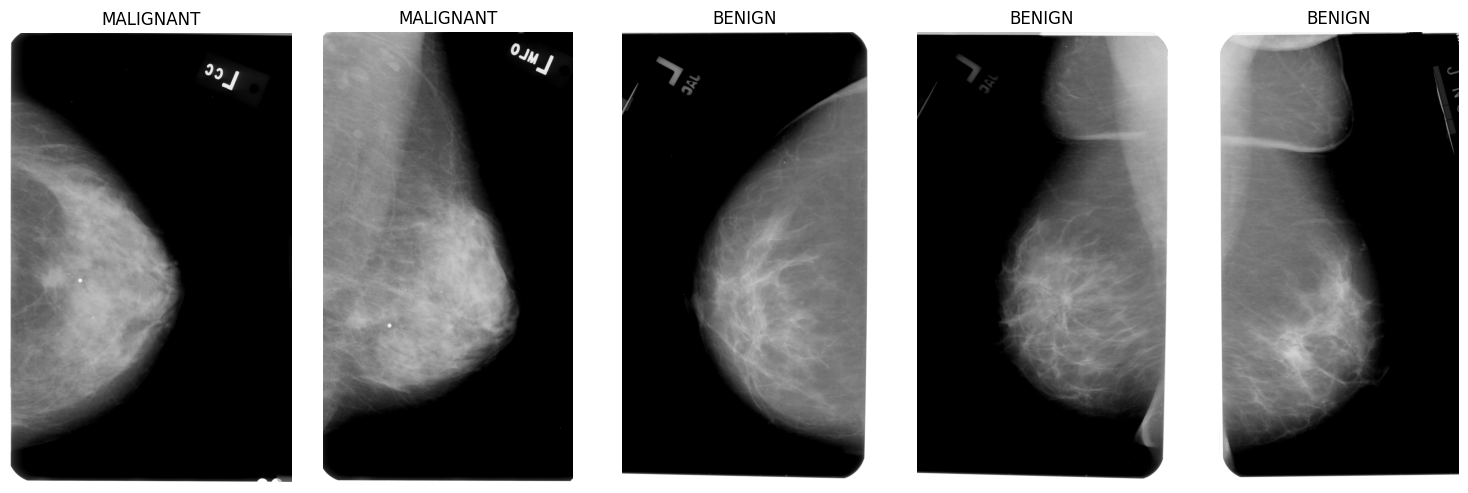

Cropped Mammograms:



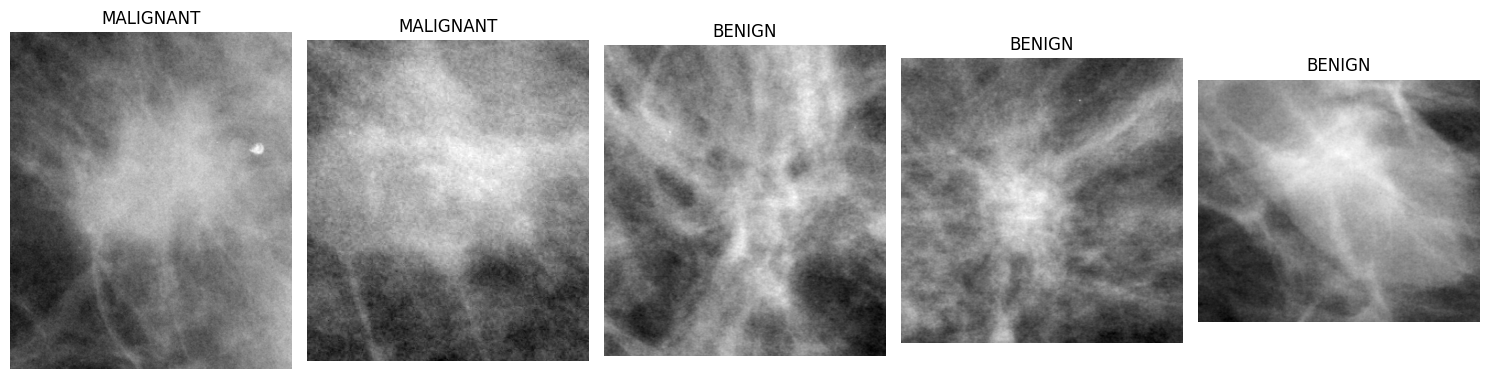

In [ ]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

def display_images(column, number):
    number_to_visualize = number
    rows = 1
    cols = number_to_visualize
    fig, axes = plt.subplots(rows, cols, figsize=(15, 5))

    for index, row in mass_train_df.head(number_to_visualize).iterrows():
        image_path = row[column]
        image = mpimg.imread(image_path)
        ax = axes[index]
        ax.imshow(image, cmap='gray')
        ax.set_title(f"{row['pathology']}")
        ax.axis('off')
    plt.tight_layout()
    plt.show()

print('Full Mammograms:\n')
display_images('image_file_path', 5)
print('Cropped Mammograms:\n')
display_images('cropped_image_file_path', 5)


In [ ]:
mass_train_df.head()

patient_id  breast_density left_or_right_breast image_view  abnormality_id  \
0    P_00001               3                 LEFT         CC               1   
1    P_00001               3                 LEFT        MLO               1   
2    P_00004               3                 LEFT         CC               1   
3    P_00004               3                 LEFT        MLO               1   
4    P_00004               3                RIGHT        MLO               1   

  abnormality_type                          mass_shape   mass_margins  \
0             mass  IRREGULAR-ARCHITECTURAL_DISTORTION     SPICULATED   
1             mass  IRREGULAR-ARCHITECTURAL_DISTORTION     SPICULATED   
2             mass            ARCHITECTURAL_DISTORTION    ILL_DEFINED   
3             mass            ARCHITECTURAL_DISTORTION    ILL_DEFINED   
4             mass                                OVAL  CIRCUMSCRIBED   

   assessment  pathology  subtlety  \
0           4  MALIGNANT         4   
1           4  MALIGNANT         4   
2           4     BENIGN         3   
3           4     BENIGN         3   
4           4     BENIGN         5   

                                     image_file_path  \
0  ../input/cbis-ddsm-breast-cancer-image-dataset...   
1  ../input/cbis-ddsm-breast-cancer-image-dataset...   
2  ../input/cbis-ddsm-breast-cancer-image-dataset...   
3  ../input/cbis-ddsm-breast-cancer-image-dataset...   
4  ../input/cbis-ddsm-breast-cancer-image-dataset...   

                             cropped_image_file_path  \
0  ../input/cbis-ddsm-breast-cancer-image-dataset...   
1  ../input/cbis-ddsm-breast-cancer-image-dataset...   
2  ../input/cbis-ddsm-breast-cancer-image-dataset...   
3  ../input/cbis-ddsm-breast-cancer-image-dataset...   
4  ../input/cbis-ddsm-breast-cancer-image-dataset...   

                                  ROI_mask_file_path  
0  Mass-Training_P_00001_LEFT_CC_1/1.3.6.1.4.1.95...  
1  Mass-Training_P_00001_LEFT_MLO_1/1.3.6.1.4.1.9...  
2  Mass-Training_P_00004_LEFT_CC_1/1.3.6.1.4.1.95...  
3  Mass-Training_P_00004_LEFT_MLO_1/1.3.6.1.4.1.9...  
4  Mass-Training_P_00004_RIGHT_MLO_1/1.3.6.1.4.1....

In [ ]:
mass_train_df.pathology.unique()

array(['MALIGNANT', 'BENIGN', 'BENIGN_WITHOUT_CALLBACK'], dtype=object)

In [ ]:
mass_train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1318 entries, 0 to 1317
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   patient_id               1318 non-null   object
 1   breast_density           1318 non-null   int64 
 2   left_or_right_breast     1318 non-null   object
 3   image_view               1318 non-null   object
 4   abnormality_id           1318 non-null   int64 
 5   abnormality_type         1318 non-null   object
 6   mass_shape               1318 non-null   object
 7   mass_margins             1318 non-null   object
 8   assessment               1318 non-null   int64 
 9   pathology                1318 non-null   object
 10  subtlety                 1318 non-null   int64 
 11  image_file_path          1318 non-null   object
 12  cropped_image_file_path  1318 non-null   object
 13  ROI_mask_file_path       1318 non-null   object
dtypes: int64(4), object(10)
memory usage: 14

In [ ]:

mass_train_df.describe()

breast_density  abnormality_id   assessment     subtlety
count     1318.000000     1318.000000  1318.000000  1318.000000
mean         2.203338        1.116085     3.504552     3.965857
std          0.873774        0.467013     1.414609     1.102032
min          1.000000        1.000000     0.000000     0.000000
25%          2.000000        1.000000     3.000000     3.000000
50%          2.000000        1.000000     4.000000     4.000000
75%          3.000000        1.000000     4.000000     5.000000
max          4.000000        6.000000     5.000000     5.000000

In [ ]:
mass_test_df.describe()

breast_density  abnormality_id  assessment    subtlety
count      378.000000      378.000000  378.000000  378.000000
mean         2.396825        1.092593    3.534392    3.785714
std          0.859455        0.398136    1.343076    1.171776
min          1.000000        1.000000    0.000000    1.000000
25%          2.000000        1.000000    3.000000    3.000000
50%          2.000000        1.000000    4.000000    4.000000
75%          3.000000        1.000000    4.000000    5.000000
max          4.000000        4.000000    5.000000    5.000000

In [ ]:
!pip install tensorflow-hub
!pip install tensorflow-addons


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 16.4 MB/s eta 0:00:00
  Attempting uninstall: typeguard
    Found existing installation: typeguard 4.3.0
    Uninstalling typeguard-4.3.0:
      Successfully uninstalled typeguard-4.3.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
inflect 7.3.1 requires typeguard>=4.0.1, but you have typeguard 2.13.3 which is incompatible.


# **Approach 1**

## CNN with Resnet50 Feature Extraction

In [ ]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import pandas as pd

def load_resnet50(input_shape):
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    model = Model(inputs=base_model.input, outputs=base_model.output)
    return model

def image_processor(image_path, target_size, feature_model):
    absolute_image_path = os.path.abspath(image_path)
    image = cv2.imread(absolute_image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (target_size[1], target_size[0]))
    image_array = preprocess_input(image)
    image_batch = np.expand_dims(image_array, axis=0)
    features = feature_model.predict(image_batch)
    return features.squeeze()

input_shape = (224, 224, 3)
resnet_model = load_resnet50(input_shape)

full_mass_df = pd.concat([mass_train_df, mass_test_df], axis=0)
target_size = (224, 224)

full_mass_df['processed_images'] = full_mass_df['image_file_path'].apply(lambda x: image_processor(x, target_size, resnet_model))




1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━

In [ ]:
import numpy as np
from keras.models import Sequential
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split



class_mapper = {'MALIGNANT': 1, 'BENIGN': 0, 'BENIGN_WITHOUT_CALLBACK': 0}
full_mass_df['labels'] = full_mass_df['pathology'].replace(class_mapper)

X_resized = np.array(full_mass_df['processed_images'].tolist())

num_classes = len(np.unique(full_mass_df['labels']))

X_train, X_val_test, y_train, y_val_test = train_test_split(X_resized, full_mass_df['labels'].values, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.33, random_state=42)

y_train_binary = y_train
y_val_binary = y_val
y_test_binary = y_test

cnn_model = Sequential([
    GlobalAveragePooling2D(input_shape=resnet_model.output_shape[1:]),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

cnn_model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

cnn_history = cnn_model.fit(X_train, y_train_binary, epochs=10, batch_size=32, validation_data=(X_val, y_val_binary))

# Evaluate the model
test_loss, test_acc = cnn_model.evaluate(X_test, y_test_binary)
print(f'Evaluation accuracy: {test_acc}')

/usr/local/lib/python3.10/dist-packages/keras/src/layers/pooling/base_global_pooling.py:12: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 5s 70ms/step - accuracy: 0.5473 - loss: 0.9091 - val_accuracy: 0.6012 - val_loss: 0.6845
Epoch 2/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5269 - loss: 0.6965 - val_accuracy: 0.5279 - val_loss: 0.6814
Epoch 3/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5898 - loss: 0.6753 - val_accuracy: 0.6188 - val_loss: 0.6501
Epoch 4/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5978 - loss: 0.6571 - val_accuracy: 0.5601 - val_loss: 0.6669
Epoch 5/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5912 - loss: 0.6521 - val_accuracy: 0.5982 - val_loss: 0.6341
Epoch 6/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6182 - loss: 0.6534 - val_accuracy: 0.5455 - val_loss: 0.6479
Epoch 7/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6032 - loss: 0.6416 - val_accuracy: 0.6217 - val_loss: 0.6304
Epoch 8/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6035 - loss: 0.6367 - val_accuracy: 0.5572 - val_loss

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Confusion Matrix:
 [[76 11]
 [54 27]]
Classification Report:
               precision    recall  f1-score   support

           0       0.58      0.87      0.70        87
           1       0.71      0.33      0.45        81

    accuracy                           0.61       168
   macro avg       0.65      0.60      0.58       168
weighted avg       0.65      0.61      0.58       168



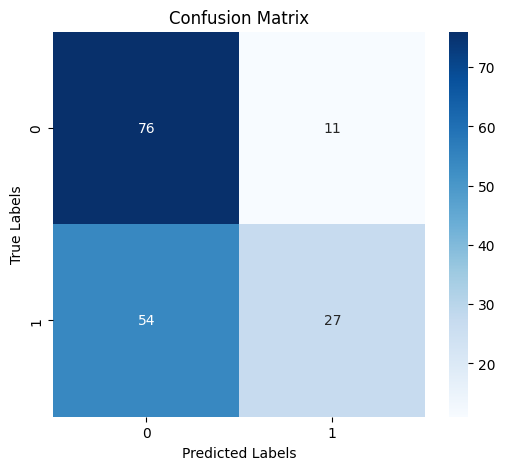

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix

y_test_pred = cnn_model.predict(X_test)
y_test_pred_labels = np.argmax(y_test_pred, axis=1)

conf_matrix = confusion_matrix(y_test_binary, y_test_pred_labels)
class_report = classification_report(y_test_binary, y_test_pred_labels, output_dict=True)

print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", classification_report(y_test_binary, y_test_pred_labels))

plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()




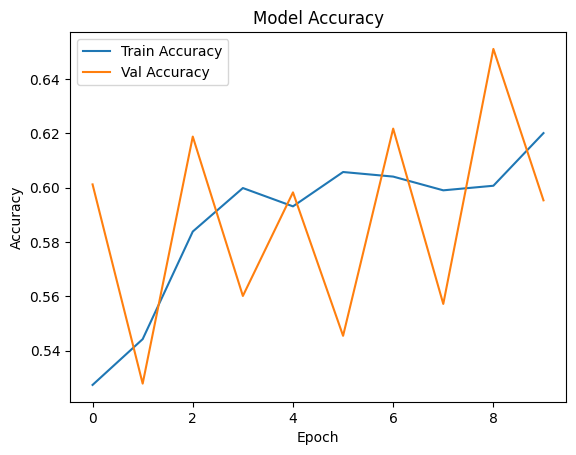

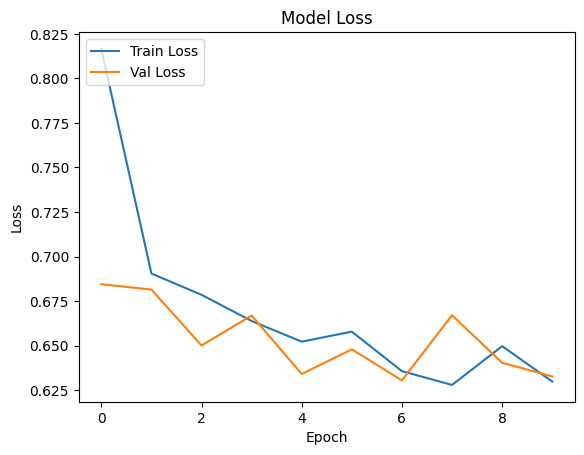

In [ ]:
import matplotlib.pyplot as plt

# Plotting training & validation accuracy values
plt.plot(cnn_history.history['accuracy'], label='Train Accuracy')
plt.plot(cnn_history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.show()

# Plotting training & validation loss values
plt.plot(cnn_history.history['loss'], label='Train Loss')
plt.plot(cnn_history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper left')
plt.show()


In [ ]:
class_mapper = {'MALIGNANT': 1, 'BENIGN': 0, 'BENIGN_WITHOUT_CALLBACK': 0}

full_mass_df['labels'] = full_mass_df['pathology'].replace(class_mapper)

X_resized = np.array(full_mass_df['processed_images'].tolist())

num_classes = len(np.unique(full_mass_df['labels']))

X_train, X_val_test, y_train, y_val_test = train_test_split(X_resized, full_mass_df['labels'].values, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.33, random_state=42)

y_train_binary = y_train
y_val_binary = y_val
y_test_binary = y_test

cnn_model = Sequential([
    GlobalAveragePooling2D(input_shape=resnet_model.output_shape[1:]),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

cnn_model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

cnn_history = cnn_model.fit(X_train, y_train_binary, epochs=50, batch_size=32, validation_data=(X_val, y_val_binary))

test_loss, test_acc = cnn_model.evaluate(X_test, y_test_binary)
print(f'Test accuracy: {test_acc}')


/usr/local/lib/python3.10/dist-packages/keras/src/layers/pooling/base_global_pooling.py:12: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 5s 69ms/step - accuracy: 0.4993 - loss: 1.0011 - val_accuracy: 0.5484 - val_loss: 0.6859
Epoch 2/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5319 - loss: 0.7497 - val_accuracy: 0.5924 - val_loss: 0.6713
Epoch 3/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5532 - loss: 0.6923 - val_accuracy: 0.6540 - val_loss: 0.6520
Epoch 4/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5689 - loss: 0.6638 - val_accuracy: 0.5191 - val_loss: 0.6733
Epoch 5/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5609 - loss: 0.6778 - val_accuracy: 0.5367 - val_loss: 0.6583
Epoch 6/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6157 - loss: 0.6457 - val_accuracy: 0.6891 - val_loss: 0.6147
Epoch 7/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6142 - loss: 0.6440 - val_accuracy: 0.6041 - val_loss: 0.6365
Epoch 8/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6048 - loss: 0.6322 - val_accuracy: 0.6217 - val_loss

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Confusion Matrix:
 [[70 17]
 [45 36]]
Classification Report:
               precision    recall  f1-score   support

           0       0.61      0.80      0.69        87
           1       0.68      0.44      0.54        81

    accuracy                           0.63       168
   macro avg       0.64      0.62      0.62       168
weighted avg       0.64      0.63      0.62       168



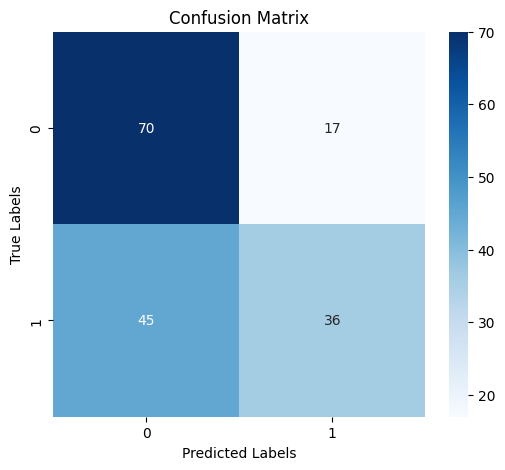

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix

y_test_pred = cnn_model.predict(X_test)
y_test_pred_labels = np.argmax(y_test_pred, axis=1)

conf_matrix = confusion_matrix(y_test_binary, y_test_pred_labels)
class_report = classification_report(y_test_binary, y_test_pred_labels, output_dict=True)

print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", classification_report(y_test_binary, y_test_pred_labels))

plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()




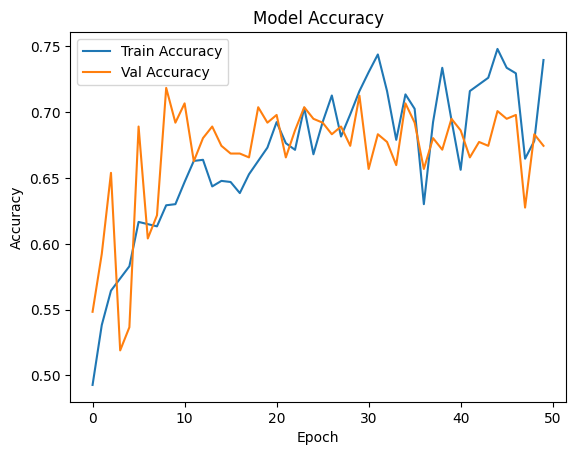

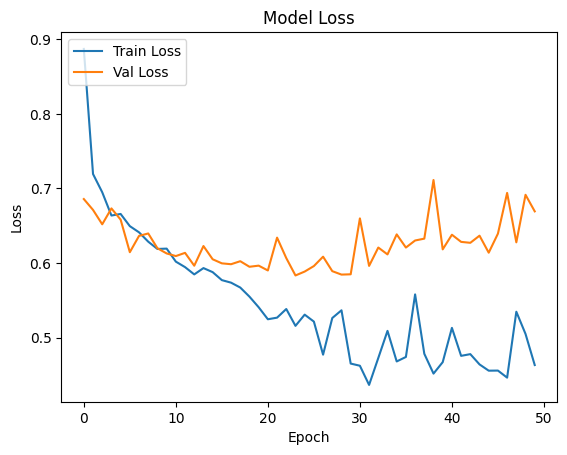

In [ ]:
import matplotlib.pyplot as plt

# Plotting training & validation accuracy values
plt.plot(cnn_history.history['accuracy'], label='Train Accuracy')
plt.plot(cnn_history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.show()

# Plotting training & validation loss values
plt.plot(cnn_history.history['loss'], label='Train Loss')
plt.plot(cnn_history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper left')
plt.show()


# **Approach 2**

## CNN with  Unet segmentation and MobileNetV2 backbone

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, Conv2D, UpSampling2D, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
import cv2
import os

def unet(input_shape):
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False

    c1 = base_model.get_layer('block_1_expand_relu').output
    c2 = base_model.get_layer('block_3_expand_relu').output
    c3 = base_model.get_layer('block_6_expand_relu').output
    c4 = base_model.get_layer('block_13_expand_relu').output
    c5 = base_model.output

    u6 = UpSampling2D((2, 2))(c5)
    u6 = Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    u6 = Concatenate()([u6, c4])

    u7 = UpSampling2D((2, 2))(u6)
    u7 = Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    u7 = Concatenate()([u7, c3])

    u8 = UpSampling2D((2, 2))(u7)
    u8 = Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    u8 = Concatenate()([u8, c2])

    u9 = UpSampling2D((2, 2))(u8)
    u9 = Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    u9 = Concatenate()([u9, c1])

    u10 = UpSampling2D((2, 2))(u9)
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(u10)

    model = Model(inputs=base_model.input, outputs=outputs)
    return model

def image_processorm(image_path, target_size, feature_model):
    absolute_image_path = os.path.abspath(image_path)
    image = cv2.imread(absolute_image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (target_size[1], target_size[0]))
    image_array = preprocess_input(image)
    image_batch = np.expand_dims(image_array, axis=0)
    segmentation_map = feature_model.predict(image_batch)
    return segmentation_map.squeeze()

input_shape = (224, 224, 3)
unet_model = unet(input_shape)
unet_model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

full_mass_df = pd.concat([mass_train_df, mass_test_df], axis=0)

target_size = (224, 224)

full_mass_df['processed_images'] = full_mass_df['image_file_path'].apply(lambda x: image_processorm(x, target_size, unet_model))


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1

In [ ]:
class_mapper = {'MALIGNANT': 1, 'BENIGN': 0, 'BENIGN_WITHOUT_CALLBACK': 0}

full_mass_df['labels'] = full_mass_df['pathology'].replace(class_mapper)

X_resized = np.array(full_mass_df['processed_images'].tolist())

num_classes = len(np.unique(full_mass_df['labels']))

X_train, X_temp, y_train, y_temp = train_test_split(X_resized, full_mass_df['labels'].values, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.33, random_state=42)

y_train = to_categorical(y_train, num_classes)
y_val = to_categorical(y_val, num_classes)
y_test = to_categorical(y_test, num_classes)


In [ ]:
y_train_binary = np.argmax(y_train, axis=1)
y_test_binary = np.argmax(y_test, axis=1)
y_val_binary = np.argmax(y_val, axis=1)

cnn_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax')
])

cnn_model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

cnn_history = cnn_model.fit(X_train, y_train_binary, epochs=10, batch_size=32, validation_data=(X_val, y_val_binary))

evaluation = cnn_model.evaluate(X_test, y_test_binary)

print("Evaluation Loss:", evaluation[0])
print("Evaluation Accuracy:", evaluation[1])


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 10s 141ms/step - accuracy: 0.4895 - loss: 0.7363 - val_accuracy: 0.5132 - val_loss: 0.6937
Epoch 2/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - accuracy: 0.5548 - loss: 0.6902 - val_accuracy: 0.5132 - val_loss: 0.6931
Epoch 3/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.5333 - loss: 0.6914 - val_accuracy: 0.5132 - val_loss: 0.6935
Epoch 4/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.5390 - loss: 0.6910 - val_accuracy: 0.5132 - val_loss: 0.6949
Epoch 5/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.5448 - loss: 0.6890 - val_accuracy: 0.5132 - val_loss: 0.6927
Epoch 6/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.5391 - loss: 0.6865 - val_accuracy: 0.5367 - val_loss: 0.6880
Epoch 7/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.5837 - loss: 0.6662 - val_accuracy: 0.5396 - val_loss: 0.6830
Epoch 8/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.6022 - loss: 0.6577 - val_accuracy: 0.6100 -

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step
Confusion Matrix:
 [[67 20]
 [53 28]]
Classification Report:
               precision    recall  f1-score   support

           0       0.56      0.77      0.65        87
           1       0.58      0.35      0.43        81

    accuracy                           0.57       168
   macro avg       0.57      0.56      0.54       168
weighted avg       0.57      0.57      0.54       168



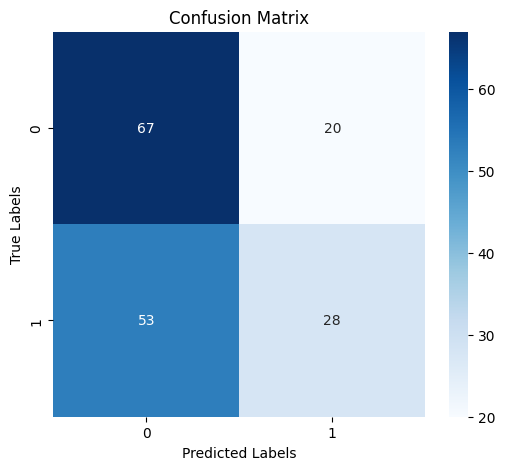

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix

y_test_pred = cnn_model.predict(X_test)
y_test_pred_labels = np.argmax(y_test_pred, axis=1)

conf_matrix = confusion_matrix(y_test_binary, y_test_pred_labels)
class_report = classification_report(y_test_binary, y_test_pred_labels, output_dict=True)

print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", classification_report(y_test_binary, y_test_pred_labels))

plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()




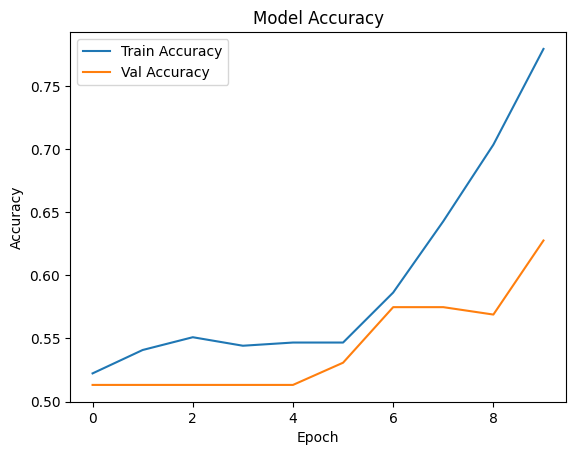

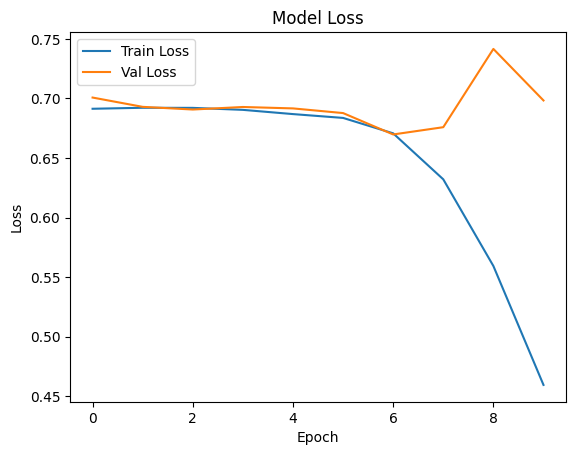

In [ ]:
import matplotlib.pyplot as plt

# Plotting training & validation accuracy values
plt.plot(cnn_history.history['accuracy'], label='Train Accuracy')
plt.plot(cnn_history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.show()

# Plotting training & validation loss values
plt.plot(cnn_history.history['loss'], label='Train Loss')
plt.plot(cnn_history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper left')
plt.show()


In [ ]:
y_train_binary = np.argmax(y_train, axis=1)
y_test_binary = np.argmax(y_test, axis=1)
y_val_binary = np.argmax(y_val, axis=1)

cnn_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax')
])

cnn_model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

cnn_history = cnn_model.fit(X_train, y_train_binary, epochs=50, batch_size=32, validation_data=(X_val, y_val_binary))

evaluation = cnn_model.evaluate(X_test, y_test_binary)

print("Evaluation Loss:", evaluation[0])
print("Evaluation Accuracy:", evaluation[1])


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 7s 120ms/step - accuracy: 0.5062 - loss: 0.7237 - val_accuracy: 0.5132 - val_loss: 0.6927
Epoch 2/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.5357 - loss: 0.6937 - val_accuracy: 0.5132 - val_loss: 0.6908
Epoch 3/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.5347 - loss: 0.6900 - val_accuracy: 0.5132 - val_loss: 0.6924
Epoch 4/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.5585 - loss: 0.6882 - val_accuracy: 0.5132 - val_loss: 0.6911
Epoch 5/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.5496 - loss: 0.6847 - val_accuracy: 0.5191 - val_loss: 0.6911
Epoch 6/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - accuracy: 0.5555 - loss: 0.6829 - val_accuracy: 0.5689 - val_loss: 0.6836
Epoch 7/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - accuracy: 0.5831 - loss: 0.6774 - val_accuracy: 0.5279 - val_loss: 0.6844
Epoch 8/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - accuracy: 0.6386 - loss: 0.6517 - val_accuracy: 0.5455 - 

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Confusion Matrix:
 [[55 32]
 [45 36]]
Classification Report:
               precision    recall  f1-score   support

           0       0.55      0.63      0.59        87
           1       0.53      0.44      0.48        81

    accuracy                           0.54       168
   macro avg       0.54      0.54      0.54       168
weighted avg       0.54      0.54      0.54       168



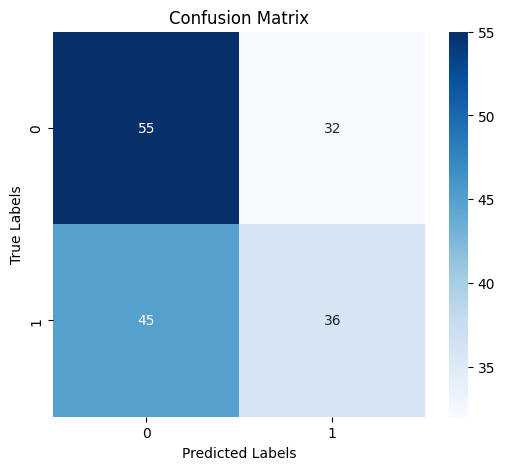

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix

y_test_pred = cnn_model.predict(X_test)
y_test_pred_labels = np.argmax(y_test_pred, axis=1)

conf_matrix = confusion_matrix(y_test_binary, y_test_pred_labels)
class_report = classification_report(y_test_binary, y_test_pred_labels, output_dict=True)

print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", classification_report(y_test_binary, y_test_pred_labels))

plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()




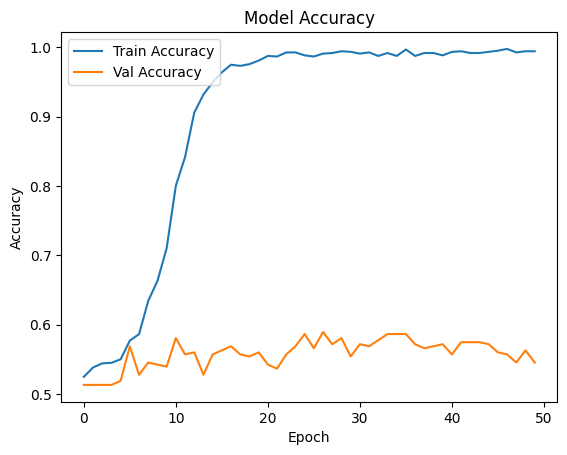

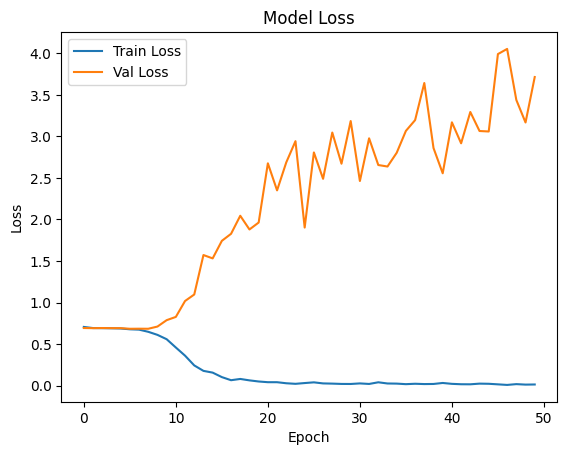

In [ ]:
import matplotlib.pyplot as plt

# Plotting training & validation accuracy values
plt.plot(cnn_history.history['accuracy'], label='Train Accuracy')
plt.plot(cnn_history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.show()

# Plotting training & validation loss values
plt.plot(cnn_history.history['loss'], label='Train Loss')
plt.plot(cnn_history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper left')
plt.show()


# **Approach 3**

## CNN with  Unet segmentation and Median filtering Denosing

In [ ]:
import os
import numpy as np
import pandas as pd
import cv2
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPooling2D, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import UpSampling2D, concatenate
from scipy.ndimage import median_filter

def build_unet(input_shape):
    inputs = Input(shape=input_shape)

    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(p3)

    u5 = UpSampling2D((2, 2))(c4)
    c5 = Conv2D(256, (3, 3), activation='relu', padding='same')(u5)

    u6 = UpSampling2D((2, 2))(c5)
    c6 = Conv2D(128, (3, 3), activation='relu', padding='same')(u6)

    u7 = UpSampling2D((2, 2))(c6)
    c7 = Conv2D(64, (3, 3), activation='relu', padding='same')(u7)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c7)

    model = Model(inputs, outputs)

    return model


In [ ]:

import os
import cv2
import numpy as np
from scipy.ndimage import median_filter

def image_processorm(image_path, target_size, unet_model):
    absolute_image_path = os.path.abspath(image_path)
    image = cv2.imread(absolute_image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (target_size[1], target_size[0]))
    image_array = image / 255.0

    image_array[:, :, 0] = median_filter(image_array[:, :, 0], size=3)
    image_array[:, :, 1] = median_filter(image_array[:, :, 1], size=3)
    image_array[:, :, 2] = median_filter(image_array[:, :, 2], size=3)

    input_image = np.expand_dims(image_array, axis=0)

    segmented_image = unet_model.predict(input_image)[0]
    segmented_image = (segmented_image > 0.5).astype(np.float32)

    image_array = image_array * segmented_image

    return image_array


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

input_shape = (224, 224, 3)
unet_model = build_unet(input_shape)
unet_model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

full_mass_df = pd.concat([mass_train_df, mass_test_df], axis=0)

target_size = (224, 224, 3)

full_mass_df['processed_images'] = full_mass_df['image_file_path'].apply(lambda x: image_processorm(x, target_size, unet_model))

class_mapper = {'MALIGNANT': 1, 'BENIGN': 0, 'BENIGN_WITHOUT_CALLBACK': 0}

full_mass_df['labels'] = full_mass_df['pathology'].replace(class_mapper)

X_resized = np.array(full_mass_df['processed_images'].tolist())

num_classes = len(np.unique(full_mass_df['labels']))

X_train, X_temp, y_train, y_temp = train_test_split(X_resized, full_mass_df['labels'].values, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.33, random_state=42)

y_train = to_categorical(y_train, num_classes)
y_val = to_categorical(y_val, num_classes)
y_test = to_categorical(y_test, num_classes)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━

In [ ]:
y_train_binary = np.argmax(y_train, axis=1)
y_test_binary = np.argmax(y_test, axis=1)
y_val_binary = np.argmax(y_val, axis=1)

cnn_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax')
])

cnn_model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

cnn_history = cnn_model.fit(X_train, y_train_binary, epochs=10, batch_size=32, validation_data=(X_val, y_val_binary))

evaluation = cnn_model.evaluate(X_test, y_test_binary)

print("Evaluation Loss:", evaluation[0])
print("Evaluation Accuracy:", evaluation[1])


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 10s 163ms/step - accuracy: 0.5357 - loss: 0.7814 - val_accuracy: 0.5132 - val_loss: 0.6929
Epoch 2/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.5263 - loss: 0.6904 - val_accuracy: 0.5132 - val_loss: 0.6920
Epoch 3/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.5328 - loss: 0.6891 - val_accuracy: 0.5132 - val_loss: 0.7078
Epoch 4/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.5710 - loss: 0.6764 - val_accuracy: 0.5689 - val_loss: 0.6837
Epoch 5/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.6073 - loss: 0.6648 - val_accuracy: 0.5572 - val_loss: 0.6936
Epoch 6/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.6344 - loss: 0.6242 - val_accuracy: 0.5806 - val_loss: 0.6767
Epoch 7/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.7494 - loss: 0.5487 - val_accuracy: 0.5396 - val_loss: 0.7525
Epoch 8/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.7562 - loss: 0.4995 - val_accuracy: 0.5748 -

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 154ms/step
Confusion Matrix:
 [[63 24]
 [46 35]]
Classification Report:
               precision    recall  f1-score   support

           0       0.58      0.72      0.64        87
           1       0.59      0.43      0.50        81

    accuracy                           0.58       168
   macro avg       0.59      0.58      0.57       168
weighted avg       0.59      0.58      0.57       168



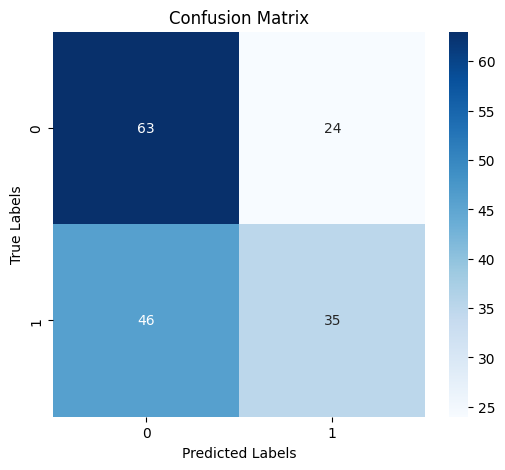

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix

y_test_pred = cnn_model.predict(X_test)
y_test_pred_labels = np.argmax(y_test_pred, axis=1)

conf_matrix = confusion_matrix(y_test_binary, y_test_pred_labels)
class_report = classification_report(y_test_binary, y_test_pred_labels, output_dict=True)

print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", classification_report(y_test_binary, y_test_pred_labels))

plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()




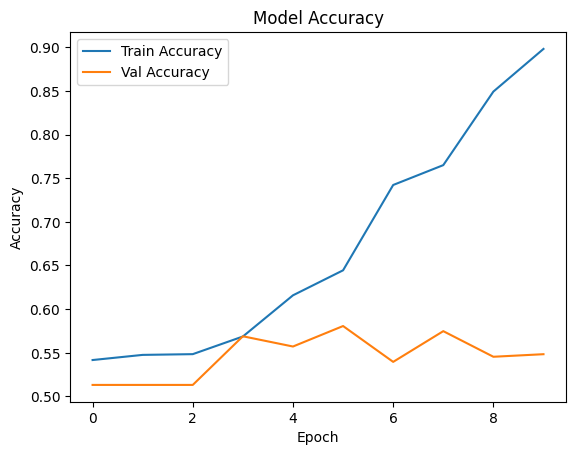

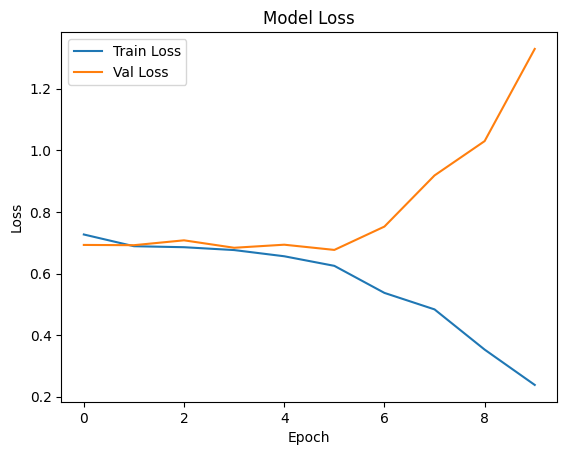

In [ ]:
import matplotlib.pyplot as plt

# Plotting training & validation accuracy values
plt.plot(cnn_history.history['accuracy'], label='Train Accuracy')
plt.plot(cnn_history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.show()

# Plotting training & validation loss values
plt.plot(cnn_history.history['loss'], label='Train Loss')
plt.plot(cnn_history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper left')
plt.show()


In [ ]:
y_train_binary = np.argmax(y_train, axis=1)
y_test_binary = np.argmax(y_test, axis=1)
y_val_binary = np.argmax(y_val, axis=1)

cnn_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax')
])

cnn_model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

cnn_history = cnn_model.fit(X_train, y_train_binary, epochs=50, batch_size=32, validation_data=(X_val, y_val_binary))

evaluation = cnn_model.evaluate(X_test, y_test_binary)

print("Evaluation Loss:", evaluation[0])
print("Evaluation Accuracy:", evaluation[1])


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 8s 136ms/step - accuracy: 0.5321 - loss: 0.9870 - val_accuracy: 0.5132 - val_loss: 0.6928
Epoch 2/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.5476 - loss: 0.6921 - val_accuracy: 0.5132 - val_loss: 0.6945
Epoch 3/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.5521 - loss: 0.6922 - val_accuracy: 0.5308 - val_loss: 0.6887
Epoch 4/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.5504 - loss: 0.6823 - val_accuracy: 0.5220 - val_loss: 0.6870
Epoch 5/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.6074 - loss: 0.6748 - val_accuracy: 0.5191 - val_loss: 0.7238
Epoch 6/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.6265 - loss: 0.6541 - val_accuracy: 0.6012 - val_loss: 0.6750
Epoch 7/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.7317 - loss: 0.5431 - val_accuracy: 0.6188 - val_loss: 0.7326
Epoch 8/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.7979 - loss: 0.4722 - val_accuracy: 0.6217 - 

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Confusion Matrix:
 [[51 36]
 [38 43]]
Classification Report:
               precision    recall  f1-score   support

           0       0.57      0.59      0.58        87
           1       0.54      0.53      0.54        81

    accuracy                           0.56       168
   macro avg       0.56      0.56      0.56       168
weighted avg       0.56      0.56      0.56       168



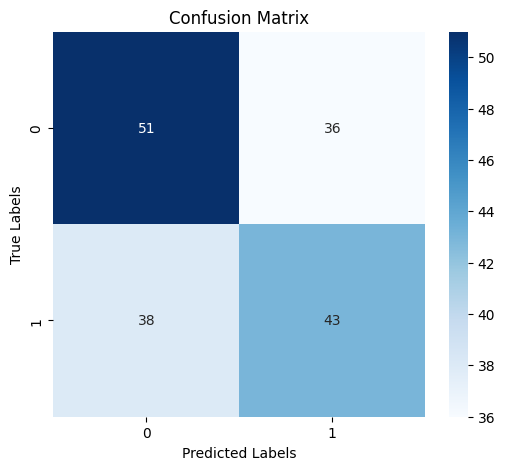

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix

y_test_pred = cnn_model.predict(X_test)
y_test_pred_labels = np.argmax(y_test_pred, axis=1)

conf_matrix = confusion_matrix(y_test_binary, y_test_pred_labels)
class_report = classification_report(y_test_binary, y_test_pred_labels, output_dict=True)

print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", classification_report(y_test_binary, y_test_pred_labels))

plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()




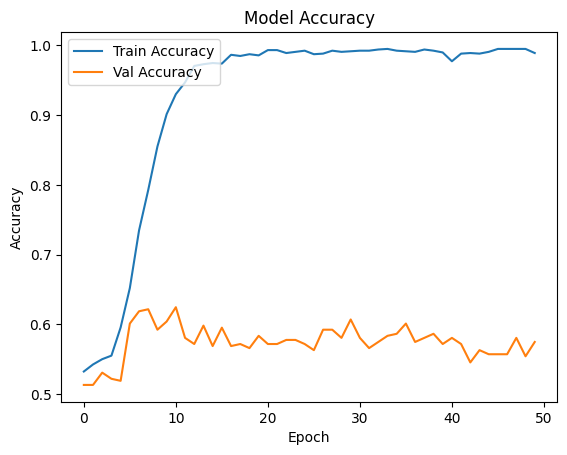

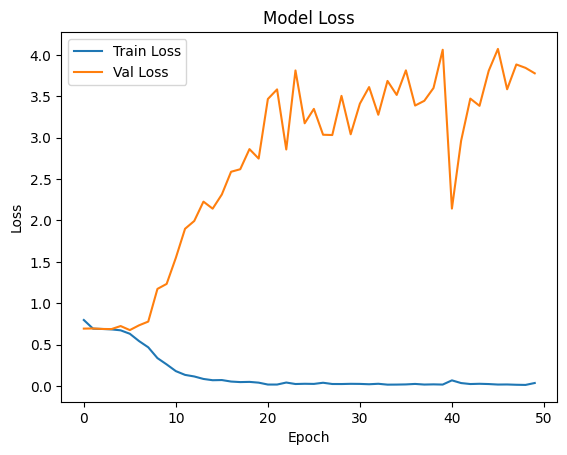

In [ ]:
import matplotlib.pyplot as plt

# Plotting training & validation accuracy values
plt.plot(cnn_history.history['accuracy'], label='Train Accuracy')
plt.plot(cnn_history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.show()

# Plotting training & validation loss values
plt.plot(cnn_history.history['loss'], label='Train Loss')
plt.plot(cnn_history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper left')
plt.show()


## CNN with Unet Segmentation and Gaussian Filtering Denoising

In [ ]:
import os
import cv2
import numpy as np
from scipy.ndimage import gaussian_filter

def image_processorg(image_path, target_size, unet_model):
    absolute_image_path = os.path.abspath(image_path)
    image = cv2.imread(absolute_image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (target_size[1], target_size[0]))
    image_array = image / 255.0

    image_array[:, :, 0] = gaussian_filter(image_array[:, :, 0], sigma=1)
    image_array[:, :, 1] = gaussian_filter(image_array[:, :, 1], sigma=1)
    image_array[:, :, 2] = gaussian_filter(image_array[:, :, 2], sigma=1)

    input_image = np.expand_dims(image_array, axis=0)

    segmented_image = unet_model.predict(input_image)[0]
    segmented_image = (segmented_image > 0.5).astype(np.float32)

    image_array = image_array * segmented_image

    return image_array


In [ ]:

input_shape = (224, 224, 3)
unet_model = build_unet(input_shape)
unet_model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

full_mass_df = pd.concat([mass_train_df, mass_test_df], axis=0)

target_size = (224, 224, 3)

full_mass_df['processed_images'] = full_mass_df['image_file_path'].apply(lambda x: image_processorg(x, target_size, unet_model))

class_mapper = {'MALIGNANT': 1, 'BENIGN': 0, 'BENIGN_WITHOUT_CALLBACK': 0}

full_mass_df['labels'] = full_mass_df['pathology'].replace(class_mapper)

X_resized = np.array(full_mass_df['processed_images'].tolist())

num_classes = len(np.unique(full_mass_df['labels']))

X_train, X_temp, y_train, y_temp = train_test_split(X_resized, full_mass_df['labels'].values, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.33, random_state=42)

y_train = to_categorical(y_train, num_classes)
y_val = to_categorical(y_val, num_classes)
y_test = to_categorical(y_test, num_classes)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━

In [ ]:
y_train_binary = np.argmax(y_train, axis=1)
y_test_binary = np.argmax(y_test, axis=1)
y_val_binary = np.argmax(y_val, axis=1)

cnn_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax')
])

cnn_model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

cnn_history = cnn_model.fit(X_train, y_train_binary, epochs=10, batch_size=32, validation_data=(X_val, y_val_binary))

evaluation = cnn_model.evaluate(X_test, y_test_binary)

print("Evaluation Loss:", evaluation[0])
print("Evaluation Accuracy:", evaluation[1])


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 8s 136ms/step - accuracy: 0.5284 - loss: 0.8545 - val_accuracy: 0.5132 - val_loss: 0.6927
Epoch 2/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.5413 - loss: 0.6907 - val_accuracy: 0.5220 - val_loss: 0.6886
Epoch 3/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.5759 - loss: 0.6862 - val_accuracy: 0.5367 - val_loss: 0.6875
Epoch 4/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.5899 - loss: 0.6718 - val_accuracy: 0.5279 - val_loss: 0.6858
Epoch 5/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.5973 - loss: 0.6514 - val_accuracy: 0.5572 - val_loss: 0.6913
Epoch 6/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.6326 - loss: 0.6292 - val_accuracy: 0.5836 - val_loss: 0.6858
Epoch 7/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.6901 - loss: 0.5943 - val_accuracy: 0.6129 - val_loss: 0.7027
Epoch 8/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.6985 - loss: 0.5652 - val_accuracy: 0.6188 - 

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Confusion Matrix:
 [[61 26]
 [47 34]]
Classification Report:
               precision    recall  f1-score   support

           0       0.56      0.70      0.63        87
           1       0.57      0.42      0.48        81

    accuracy                           0.57       168
   macro avg       0.57      0.56      0.55       168
weighted avg       0.57      0.57      0.56       168



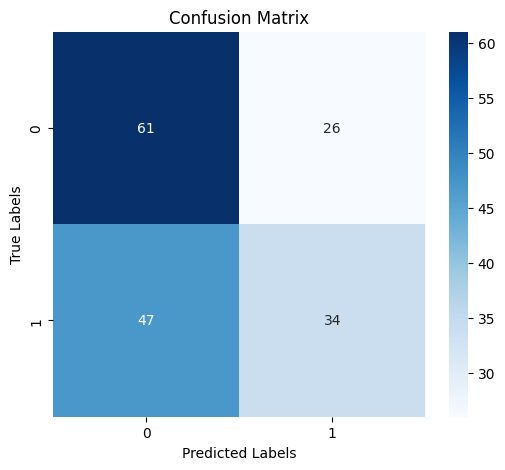

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix

y_test_pred = cnn_model.predict(X_test)
y_test_pred_labels = np.argmax(y_test_pred, axis=1)

conf_matrix = confusion_matrix(y_test_binary, y_test_pred_labels)
class_report = classification_report(y_test_binary, y_test_pred_labels, output_dict=True)

print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", classification_report(y_test_binary, y_test_pred_labels))

plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()




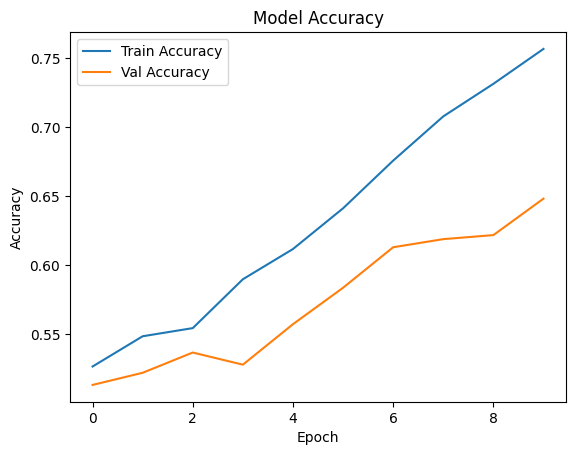

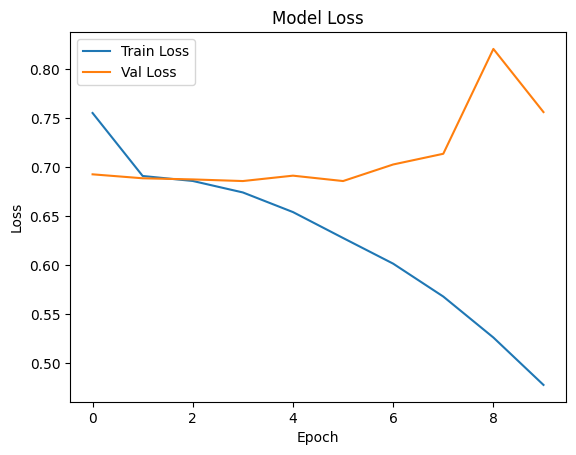

In [ ]:
import matplotlib.pyplot as plt

# Plotting training & validation accuracy values
plt.plot(cnn_history.history['accuracy'], label='Train Accuracy')
plt.plot(cnn_history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.show()

# Plotting training & validation loss values
plt.plot(cnn_history.history['loss'], label='Train Loss')
plt.plot(cnn_history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper left')
plt.show()


In [ ]:
y_train_binary = np.argmax(y_train, axis=1)
y_test_binary = np.argmax(y_test, axis=1)
y_val_binary = np.argmax(y_val, axis=1)

cnn_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax')
])

cnn_model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

cnn_history = cnn_model.fit(X_train, y_train_binary, epochs=50, batch_size=32, validation_data=(X_val, y_val_binary))

evaluation = cnn_model.evaluate(X_test, y_test_binary)

print("Evaluation Loss:", evaluation[0])
print("Evaluation Accuracy:", evaluation[1])


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 8s 137ms/step - accuracy: 0.5281 - loss: 0.7594 - val_accuracy: 0.5161 - val_loss: 0.6909
Epoch 2/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.5688 - loss: 0.6852 - val_accuracy: 0.5191 - val_loss: 0.7143
Epoch 3/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.5866 - loss: 0.6804 - val_accuracy: 0.5249 - val_loss: 0.6866
Epoch 4/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.5849 - loss: 0.6699 - val_accuracy: 0.5572 - val_loss: 0.6797
Epoch 5/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.6063 - loss: 0.6524 - val_accuracy: 0.5894 - val_loss: 0.6818
Epoch 6/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.6892 - loss: 0.6023 - val_accuracy: 0.5777 - val_loss: 0.7660
Epoch 7/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.7062 - loss: 0.5740 - val_accuracy: 0.6334 - val_loss: 0.7220
Epoch 8/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.7499 - loss: 0.5176 - val_accuracy: 0.6598 - 

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Confusion Matrix:
 [[62 25]
 [38 43]]
Classification Report:
               precision    recall  f1-score   support

           0       0.62      0.71      0.66        87
           1       0.63      0.53      0.58        81

    accuracy                           0.62       168
   macro avg       0.63      0.62      0.62       168
weighted avg       0.63      0.62      0.62       168



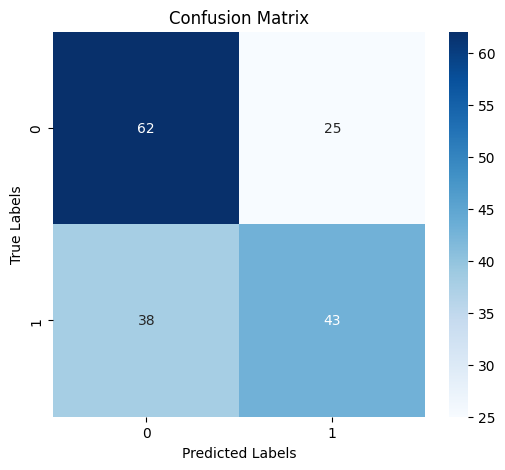

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix

y_test_pred = cnn_model.predict(X_test)
y_test_pred_labels = np.argmax(y_test_pred, axis=1)

conf_matrix = confusion_matrix(y_test_binary, y_test_pred_labels)
class_report = classification_report(y_test_binary, y_test_pred_labels, output_dict=True)

print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", classification_report(y_test_binary, y_test_pred_labels))

plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()




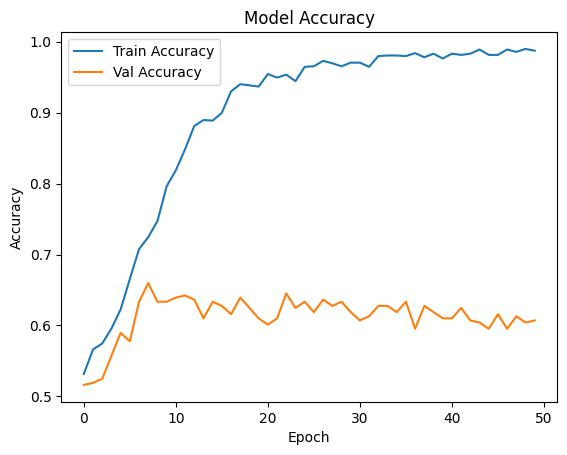

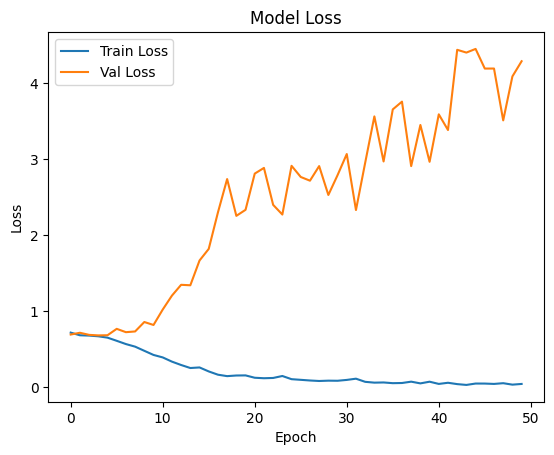

In [ ]:
import matplotlib.pyplot as plt

# Plotting training & validation accuracy values
plt.plot(cnn_history.history['accuracy'], label='Train Accuracy')
plt.plot(cnn_history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.show()

# Plotting training & validation loss values
plt.plot(cnn_history.history['loss'], label='Train Loss')
plt.plot(cnn_history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper left')
plt.show()


## CNN with Unet Segmentation with Bilateral Filtering

In [ ]:
import os
import cv2
import numpy as np

def image_processorb(image_path, target_size, unet_model):
    absolute_image_path = os.path.abspath(image_path)
    image = cv2.imread(absolute_image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (target_size[1], target_size[0]))
    image_array = image / 255.0

    image_array_8bit = (image_array * 255).astype(np.uint8)

    filtered_image = np.zeros_like(image_array_8bit)
    for i in range(3):
        filtered_image[:, :, i] = cv2.bilateralFilter(image_array_8bit[:, :, i], d=9, sigmaColor=75, sigmaSpace=75)

    filtered_image = filtered_image.astype(np.float32) / 255.0

    input_image = np.expand_dims(filtered_image, axis=0)

    segmented_image = unet_model.predict(input_image)[0]
    segmented_image = (segmented_image > 0.5).astype(np.float32)

    final_image = filtered_image * segmented_image

    return final_image


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam

input_shape = (224, 224, 3)
unet_model = build_unet(input_shape)
unet_model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

full_mass_df = pd.concat([mass_train_df, mass_test_df], axis=0)

target_size = (224, 224, 3)

full_mass_df['processed_images'] = full_mass_df['image_file_path'].apply(lambda x: image_processorb(x, target_size, unet_model))

class_mapper = {'MALIGNANT': 1, 'BENIGN': 0, 'BENIGN_WITHOUT_CALLBACK': 0}

full_mass_df['labels'] = full_mass_df['pathology'].replace(class_mapper)

X_resized = np.array(full_mass_df['processed_images'].tolist())

num_classes = len(np.unique(full_mass_df['labels']))

X_train, X_temp, y_train, y_temp = train_test_split(X_resized, full_mass_df['labels'].values, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.33, random_state=42)

y_train = to_categorical(y_train, num_classes)
y_val = to_categorical(y_val, num_classes)
y_test = to_categorical(y_test, num_classes)


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━

In [ ]:
y_train_binary = np.argmax(y_train, axis=1)
y_test_binary = np.argmax(y_test, axis=1)
y_val_binary = np.argmax(y_val, axis=1)

cnn_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax')
])

cnn_model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

cnn_history = cnn_model.fit(X_train, y_train_binary, epochs=10, batch_size=32, validation_data=(X_val, y_val_binary))

evaluation = cnn_model.evaluate(X_test, y_test_binary)

print("Evaluation Loss:", evaluation[0])
print("Evaluation Accuracy:", evaluation[1])


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 15s 219ms/step - accuracy: 0.5293 - loss: 0.6897 - val_accuracy: 0.5132 - val_loss: 0.6926
Epoch 2/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - accuracy: 0.5332 - loss: 0.6907 - val_accuracy: 0.5337 - val_loss: 0.6903
Epoch 3/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - accuracy: 0.5465 - loss: 0.6914 - val_accuracy: 0.5601 - val_loss: 0.6872
Epoch 4/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - accuracy: 0.5569 - loss: 0.6864 - val_accuracy: 0.5513 - val_loss: 0.6862
Epoch 5/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - accuracy: 0.6029 - loss: 0.6751 - val_accuracy: 0.5572 - val_loss: 0.6914
Epoch 6/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - accuracy: 0.6068 - loss: 0.6540 - val_accuracy: 0.5689 - val_loss: 0.7047
Epoch 7/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - accuracy: 0.6816 - loss: 0.6031 - val_accuracy: 0.5689 - val_loss: 0.7101
Epoch 8/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - accuracy: 0.6720 - loss: 0.5826 - val_accuracy: 0.5924 -

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step
Confusion Matrix:
 [[48 39]
 [46 35]]
Classification Report:
               precision    recall  f1-score   support

           0       0.51      0.55      0.53        87
           1       0.47      0.43      0.45        81

    accuracy                           0.49       168
   macro avg       0.49      0.49      0.49       168
weighted avg       0.49      0.49      0.49       168



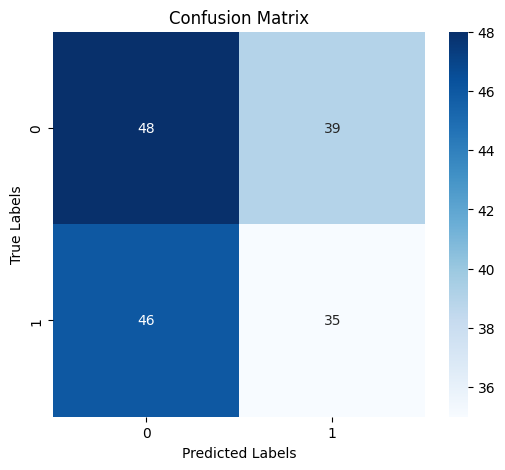

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix

y_test_pred = cnn_model.predict(X_test)
y_test_pred_labels = np.argmax(y_test_pred, axis=1)

conf_matrix = confusion_matrix(y_test_binary, y_test_pred_labels)
class_report = classification_report(y_test_binary, y_test_pred_labels, output_dict=True)

print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", classification_report(y_test_binary, y_test_pred_labels))

plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()




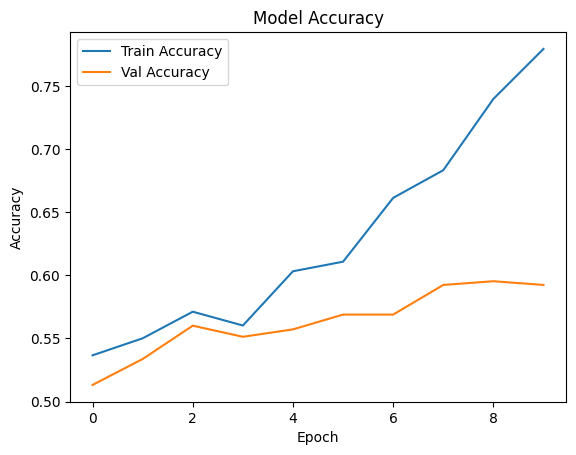

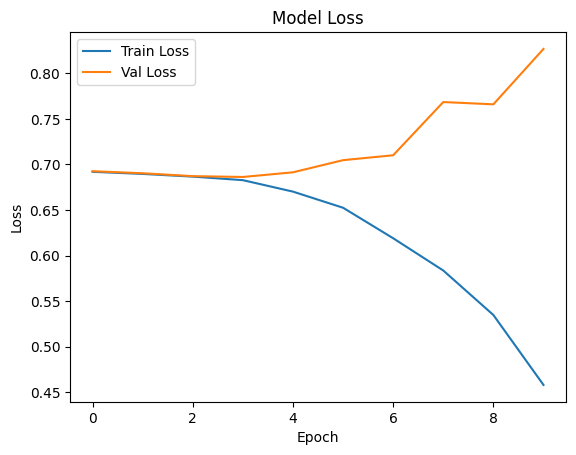

In [ ]:
import matplotlib.pyplot as plt

# Plotting training & validation accuracy values
plt.plot(cnn_history.history['accuracy'], label='Train Accuracy')
plt.plot(cnn_history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.show()

# Plotting training & validation loss values
plt.plot(cnn_history.history['loss'], label='Train Loss')
plt.plot(cnn_history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper left')
plt.show()


In [ ]:
y_train_binary = np.argmax(y_train, axis=1)
y_test_binary = np.argmax(y_test, axis=1)
y_val_binary = np.argmax(y_val, axis=1)

cnn_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax')
])

cnn_model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

cnn_history = cnn_model.fit(X_train, y_train_binary, epochs=50, batch_size=32, validation_data=(X_val, y_val_binary))

evaluation = cnn_model.evaluate(X_test, y_test_binary)

print("Evaluation Loss:", evaluation[0])
print("Evaluation Accuracy:", evaluation[1])


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 9s 142ms/step - accuracy: 0.4921 - loss: 0.7014 - val_accuracy: 0.5132 - val_loss: 0.6926
Epoch 2/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.5324 - loss: 0.6923 - val_accuracy: 0.5161 - val_loss: 0.6917
Epoch 3/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.5597 - loss: 0.6855 - val_accuracy: 0.5572 - val_loss: 0.6859
Epoch 4/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.5701 - loss: 0.6803 - val_accuracy: 0.5396 - val_loss: 0.6899
Epoch 5/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.6256 - loss: 0.6582 - val_accuracy: 0.5630 - val_loss: 0.6874
Epoch 6/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.6465 - loss: 0.6387 - val_accuracy: 0.6070 - val_loss: 0.7071
Epoch 7/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.6738 - loss: 0.6111 - val_accuracy: 0.5865 - val_loss: 0.7516
Epoch 8/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.7404 - loss: 0.5048 - val_accuracy: 0.5836 - 

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step
Confusion Matrix:
 [[53 34]
 [47 34]]
Classification Report:
               precision    recall  f1-score   support

           0       0.53      0.61      0.57        87
           1       0.50      0.42      0.46        81

    accuracy                           0.52       168
   macro avg       0.52      0.51      0.51       168
weighted avg       0.52      0.52      0.51       168



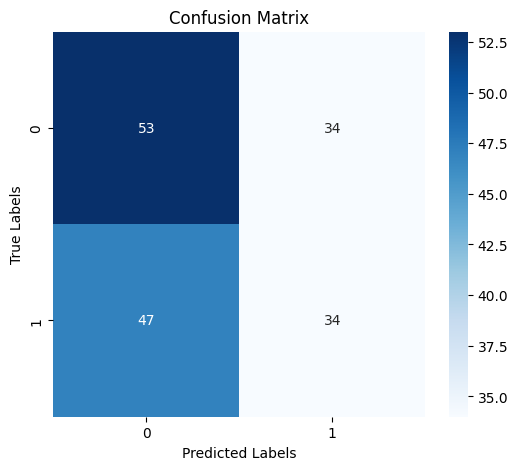

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix

y_test_pred = cnn_model.predict(X_test)
y_test_pred_labels = np.argmax(y_test_pred, axis=1)

conf_matrix = confusion_matrix(y_test_binary, y_test_pred_labels)
class_report = classification_report(y_test_binary, y_test_pred_labels, output_dict=True)

print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", classification_report(y_test_binary, y_test_pred_labels))

plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()




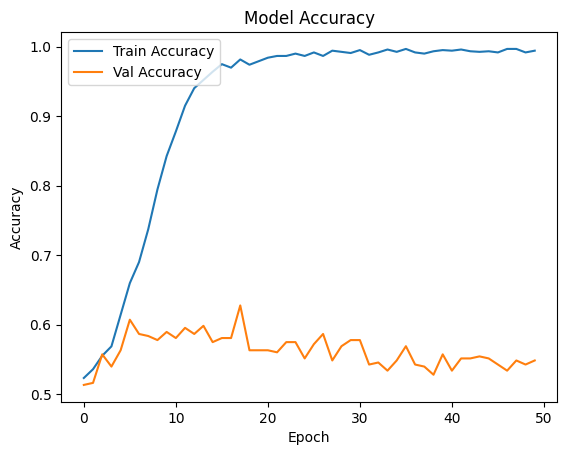

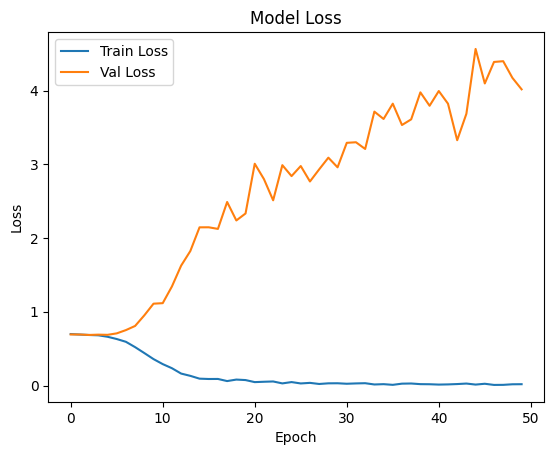

In [ ]:
import matplotlib.pyplot as plt

# Plotting training & validation accuracy values
plt.plot(cnn_history.history['accuracy'], label='Train Accuracy')
plt.plot(cnn_history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.show()

# Plotting training & validation loss values
plt.plot(cnn_history.history['loss'], label='Train Loss')
plt.plot(cnn_history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper left')
plt.show()


## CNN with Unet Segmentation and NLM denoising

In [ ]:
import os
import cv2
import numpy as np

def image_processornlm(image_path, target_size, unet_model):
    absolute_image_path = os.path.abspath(image_path)

    image = cv2.imread(absolute_image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    image = cv2.resize(image, (target_size[1], target_size[0]))

    image_uint8 = (image * 255).astype(np.uint8)

    filtered_image = cv2.fastNlMeansDenoisingColored(image_uint8, None, 10, 10, 7, 21)

    filtered_image = filtered_image.astype(np.float32) / 255.0

    input_image = np.expand_dims(filtered_image, axis=0)

    segmented_image = unet_model.predict(input_image)[0]
    segmented_image = (segmented_image > 0.5).astype(np.float32)

    final_image = filtered_image * segmented_image

    return final_image


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam

input_shape = (224, 224, 3)
unet_model = build_unet(input_shape)
unet_model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

full_mass_df = pd.concat([mass_train_df, mass_test_df], axis=0)

target_size = (224, 224, 3)

full_mass_df['processed_images'] = full_mass_df['image_file_path'].apply(lambda x: image_processornlm(x, target_size, unet_model))

class_mapper = {'MALIGNANT': 1, 'BENIGN': 0, 'BENIGN_WITHOUT_CALLBACK': 0}

full_mass_df['labels'] = full_mass_df['pathology'].replace(class_mapper)

X_resized = np.array(full_mass_df['processed_images'].tolist())

num_classes = len(np.unique(full_mass_df['labels']))

X_train, X_temp, y_train, y_temp = train_test_split(X_resized, full_mass_df['labels'].values, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.33, random_state=42)

y_train = to_categorical(y_train, num_classes)
y_val = to_categorical(y_val, num_classes)
y_test = to_categorical(y_test, num_classes)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━

In [ ]:
y_train_binary = np.argmax(y_train, axis=1)
y_test_binary = np.argmax(y_test, axis=1)
y_val_binary = np.argmax(y_val, axis=1)

cnn_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax')
])

cnn_model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

cnn_history = cnn_model.fit(X_train, y_train_binary, epochs=10, batch_size=32, validation_data=(X_val, y_val_binary))

evaluation = cnn_model.evaluate(X_test, y_test_binary)

print("Evaluation Loss:", evaluation[0])
print("Evaluation Accuracy:", evaluation[1])


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 8s 135ms/step - accuracy: 0.5146 - loss: 0.8334 - val_accuracy: 0.5220 - val_loss: 0.6854
Epoch 2/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.5638 - loss: 0.6769 - val_accuracy: 0.6305 - val_loss: 0.6712
Epoch 3/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.6055 - loss: 0.6539 - val_accuracy: 0.6129 - val_loss: 0.6564
Epoch 4/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.6613 - loss: 0.6173 - val_accuracy: 0.6481 - val_loss: 0.6437
Epoch 5/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.7432 - loss: 0.5648 - val_accuracy: 0.6364 - val_loss: 0.6712
Epoch 6/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.7589 - loss: 0.4973 - val_accuracy: 0.5924 - val_loss: 0.7360
Epoch 7/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.8477 - loss: 0.3504 - val_accuracy: 0.5953 - val_loss: 0.7213
Epoch 8/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.8995 - loss: 0.2696 - val_accuracy: 0.6129 - 

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Confusion Matrix:
 [[48 39]
 [23 58]]
Classification Report:
               precision    recall  f1-score   support

           0       0.68      0.55      0.61        87
           1       0.60      0.72      0.65        81

    accuracy                           0.63       168
   macro avg       0.64      0.63      0.63       168
weighted avg       0.64      0.63      0.63       168



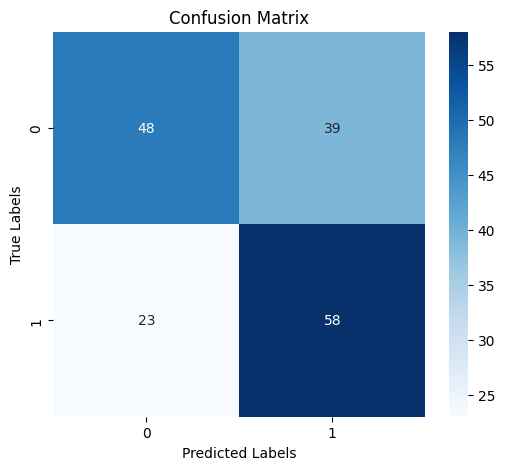

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix

y_test_pred = cnn_model.predict(X_test)
y_test_pred_labels = np.argmax(y_test_pred, axis=1)

conf_matrix = confusion_matrix(y_test_binary, y_test_pred_labels)
class_report = classification_report(y_test_binary, y_test_pred_labels, output_dict=True)

print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", classification_report(y_test_binary, y_test_pred_labels))

plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()




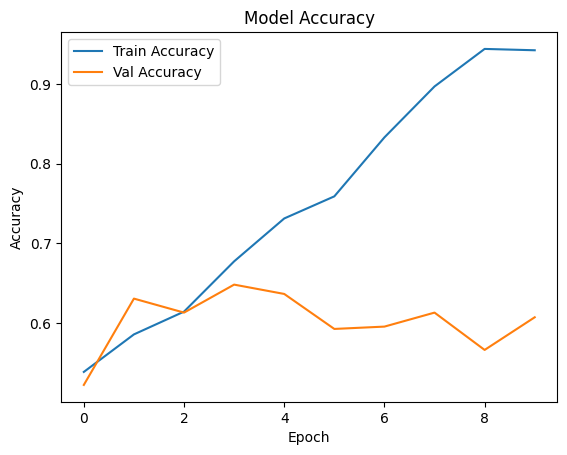

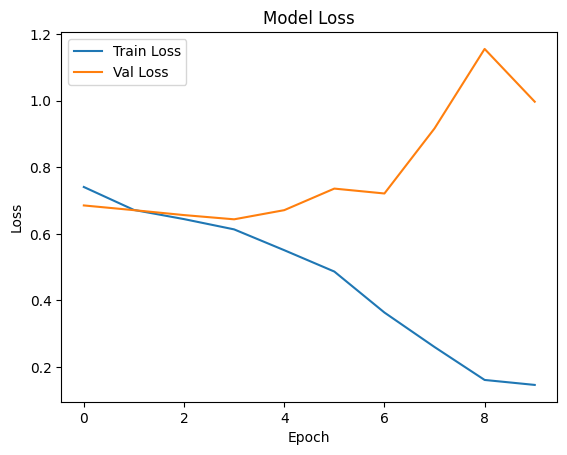

In [ ]:
import matplotlib.pyplot as plt

# Plotting training & validation accuracy values
plt.plot(cnn_history.history['accuracy'], label='Train Accuracy')
plt.plot(cnn_history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.show()

# Plotting training & validation loss values
plt.plot(cnn_history.history['loss'], label='Train Loss')
plt.plot(cnn_history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper left')
plt.show()


In [ ]:
y_train_binary = np.argmax(y_train, axis=1)
y_test_binary = np.argmax(y_test, axis=1)
y_val_binary = np.argmax(y_val, axis=1)

cnn_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax')
])

cnn_model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

cnn_history = cnn_model.fit(X_train, y_train_binary, epochs=50, batch_size=32, validation_data=(X_val, y_val_binary))

evaluation = cnn_model.evaluate(X_test, y_test_binary)

print("Evaluation Loss:", evaluation[0])
print("Evaluation Accuracy:", evaluation[1])


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 8s 135ms/step - accuracy: 0.5182 - loss: 0.9014 - val_accuracy: 0.5132 - val_loss: 0.6897
Epoch 2/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.5363 - loss: 0.6860 - val_accuracy: 0.5396 - val_loss: 0.6720
Epoch 3/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.5944 - loss: 0.6539 - val_accuracy: 0.5894 - val_loss: 0.6551
Epoch 4/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.6478 - loss: 0.6194 - val_accuracy: 0.6334 - val_loss: 0.6448
Epoch 5/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.7071 - loss: 0.5672 - val_accuracy: 0.6129 - val_loss: 0.6484
Epoch 6/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.7773 - loss: 0.5011 - val_accuracy: 0.6188 - val_loss: 0.7208
Epoch 7/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.8444 - loss: 0.3826 - val_accuracy: 0.5777 - val_loss: 0.8802
Epoch 8/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.9070 - loss: 0.2630 - val_accuracy: 0.5865 - 

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Confusion Matrix:
 [[57 30]
 [26 55]]
Classification Report:
               precision    recall  f1-score   support

           0       0.69      0.66      0.67        87
           1       0.65      0.68      0.66        81

    accuracy                           0.67       168
   macro avg       0.67      0.67      0.67       168
weighted avg       0.67      0.67      0.67       168



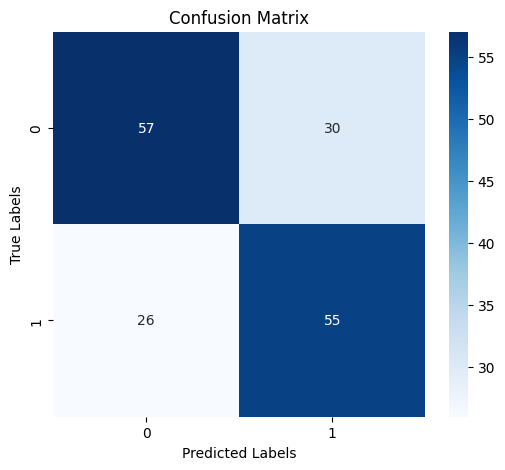

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix

y_test_pred = cnn_model.predict(X_test)
y_test_pred_labels = np.argmax(y_test_pred, axis=1)

conf_matrix = confusion_matrix(y_test_binary, y_test_pred_labels)
class_report = classification_report(y_test_binary, y_test_pred_labels, output_dict=True)

print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", classification_report(y_test_binary, y_test_pred_labels))

plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()




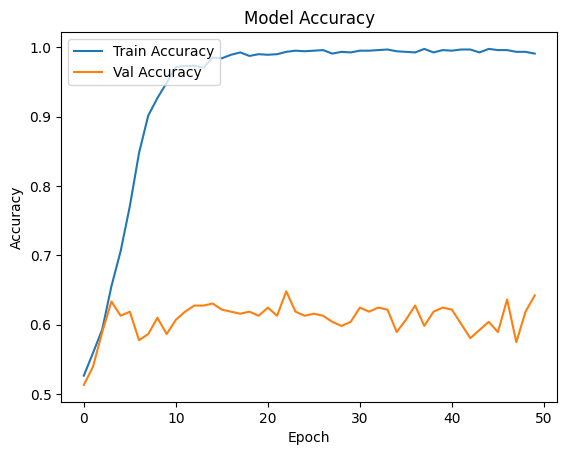

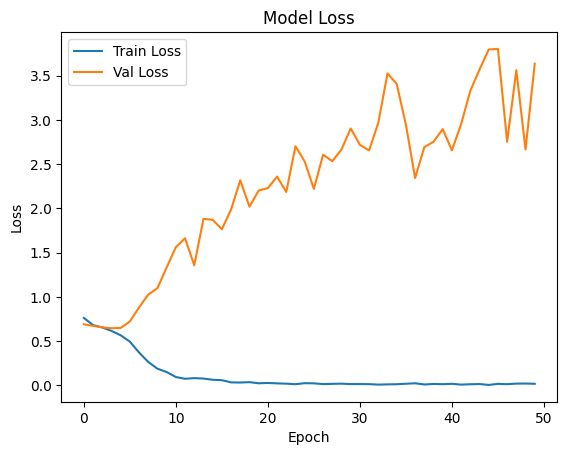

In [ ]:
import matplotlib.pyplot as plt

# Plotting training & validation accuracy values
plt.plot(cnn_history.history['accuracy'], label='Train Accuracy')
plt.plot(cnn_history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.show()

# Plotting training & validation loss values
plt.plot(cnn_history.history['loss'], label='Train Loss')
plt.plot(cnn_history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper left')
plt.show()


## CNN with Unet Segmentation and Total variation denoising

In [ ]:
import os
import cv2
import numpy as np
from skimage.restoration import denoise_tv_chambolle

def image_processortv(image_path, target_size, unet_model):
    absolute_image_path = os.path.abspath(image_path)
    image = cv2.imread(absolute_image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (target_size[1], target_size[0]))
    image_array = image / 255.0

    denoised_image = np.zeros_like(image_array)
    for i in range(3):
        denoised_image[:, :, i] = denoise_tv_chambolle(image_array[:, :, i], weight=0.1)

    input_image = np.expand_dims(denoised_image, axis=0)

    segmented_image = unet_model.predict(input_image)[0]
    segmented_image = (segmented_image > 0.5).astype(np.float32)

    final_image = denoised_image * segmented_image

    return final_image


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam

input_shape = (224, 224, 3)
unet_model = build_unet(input_shape)
unet_model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

full_mass_df = pd.concat([mass_train_df, mass_test_df], axis=0)

target_size = (224, 224, 3)

full_mass_df['processed_images'] = full_mass_df['image_file_path'].apply(lambda x: image_processortv(x, target_size, unet_model))

class_mapper = {'MALIGNANT': 1, 'BENIGN': 0, 'BENIGN_WITHOUT_CALLBACK': 0}

full_mass_df['labels'] = full_mass_df['pathology'].replace(class_mapper)

X_resized = np.array(full_mass_df['processed_images'].tolist())

num_classes = len(np.unique(full_mass_df['labels']))

X_train, X_temp, y_train, y_temp = train_test_split(X_resized, full_mass_df['labels'].values, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.33, random_state=42)

y_train = to_categorical(y_train, num_classes)
y_val = to_categorical(y_val, num_classes)
y_test = to_categorical(y_test, num_classes)


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━

In [ ]:
y_train_binary = np.argmax(y_train, axis=1)
y_test_binary = np.argmax(y_test, axis=1)
y_val_binary = np.argmax(y_val, axis=1)

cnn_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax')
])

cnn_model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

cnn_history = cnn_model.fit(X_train, y_train_binary, epochs=10, batch_size=32, validation_data=(X_val, y_val_binary))

evaluation = cnn_model.evaluate(X_test, y_test_binary)


print("Evaluation Loss:", evaluation[0])
print("Evaluation Accuracy:", evaluation[1])


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 16s 231ms/step - accuracy: 0.5186 - loss: 0.7245 - val_accuracy: 0.5132 - val_loss: 0.7005
Epoch 2/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - accuracy: 0.5500 - loss: 0.6903 - val_accuracy: 0.5132 - val_loss: 0.6911
Epoch 3/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - accuracy: 0.5269 - loss: 0.6907 - val_accuracy: 0.5132 - val_loss: 0.7281
Epoch 4/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.5499 - loss: 0.6953 - val_accuracy: 0.5132 - val_loss: 0.6906
Epoch 5/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.5618 - loss: 0.6794 - val_accuracy: 0.5894 - val_loss: 0.6824
Epoch 6/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.6129 - loss: 0.6578 - val_accuracy: 0.5836 - val_loss: 0.6722
Epoch 7/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.6715 - loss: 0.6119 - val_accuracy: 0.5806 - val_loss: 0.6754
Epoch 8/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.7051 - loss: 0.5636 - val_accuracy: 0.5777 -

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Confusion Matrix:
 [[70 17]
 [56 25]]
Classification Report:
               precision    recall  f1-score   support

           0       0.56      0.80      0.66        87
           1       0.60      0.31      0.41        81

    accuracy                           0.57       168
   macro avg       0.58      0.56      0.53       168
weighted avg       0.57      0.57      0.54       168



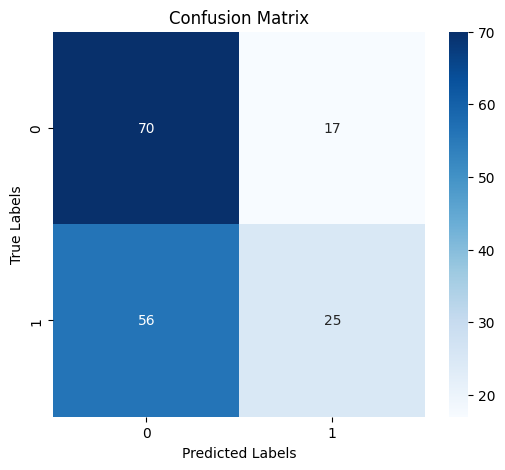

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix

y_test_pred = cnn_model.predict(X_test)
y_test_pred_labels = np.argmax(y_test_pred, axis=1)

conf_matrix = confusion_matrix(y_test_binary, y_test_pred_labels)
class_report = classification_report(y_test_binary, y_test_pred_labels, output_dict=True)

print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", classification_report(y_test_binary, y_test_pred_labels))

plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()




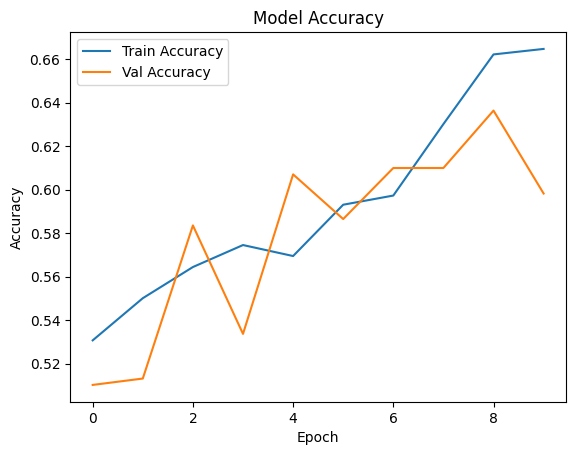

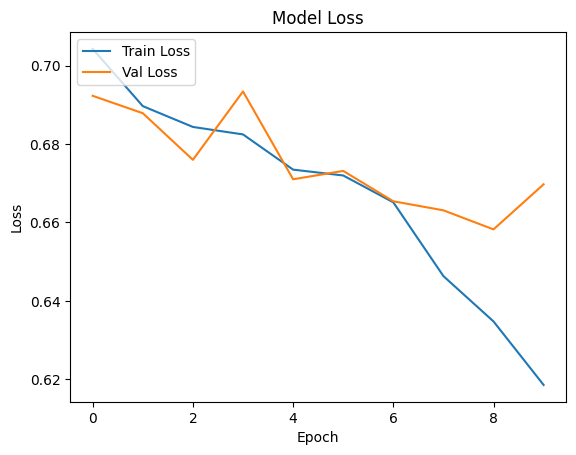

In [ ]:
import matplotlib.pyplot as plt

# Plotting training & validation accuracy values
plt.plot(cnn_history.history['accuracy'], label='Train Accuracy')
plt.plot(cnn_history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.show()

# Plotting training & validation loss values
plt.plot(cnn_history.history['loss'], label='Train Loss')
plt.plot(cnn_history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper left')
plt.show()


In [ ]:
y_train_binary = np.argmax(y_train, axis=1)
y_test_binary = np.argmax(y_test, axis=1)
y_val_binary = np.argmax(y_val, axis=1)

cnn_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax')
])

cnn_model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

cnn_history = cnn_model.fit(X_train, y_train_binary, epochs=50, batch_size=32, validation_data=(X_val, y_val_binary))

evaluation = cnn_model.evaluate(X_test, y_test_binary)


print("Evaluation Loss:", evaluation[0])
print("Evaluation Accuracy:", evaluation[1])


Epoch 1/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 8s 139ms/step - accuracy: 0.5233 - loss: 0.7847 - val_accuracy: 0.5132 - val_loss: 0.6931
Epoch 2/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.5461 - loss: 0.6899 - val_accuracy: 0.5132 - val_loss: 0.6929
Epoch 3/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.5719 - loss: 0.6862 - val_accuracy: 0.5337 - val_loss: 0.6868
Epoch 4/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.5568 - loss: 0.6849 - val_accuracy: 0.5103 - val_loss: 0.6905
Epoch 5/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.5652 - loss: 0.6800 - val_accuracy: 0.5425 - val_loss: 0.6810
Epoch 6/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.6223 - loss: 0.6547 - val_accuracy: 0.5513 - val_loss: 0.6802
Epoch 7/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.6046 - loss: 0.6532 - val_accuracy: 0.6012 - val_loss: 0.6686
Epoch 8/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - accuracy: 0.6773 - loss: 0.6061 - val_accuracy: 0.6158 - 

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step
Confusion Matrix:
 [[59 28]
 [49 32]]
Classification Report:
               precision    recall  f1-score   support

           0       0.55      0.68      0.61        87
           1       0.53      0.40      0.45        81

    accuracy                           0.54       168
   macro avg       0.54      0.54      0.53       168
weighted avg       0.54      0.54      0.53       168



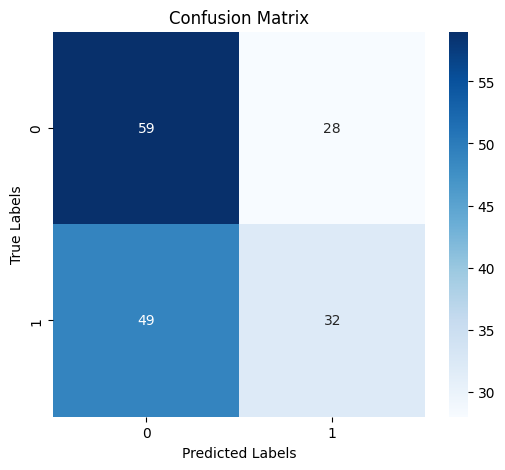

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix

y_test_pred = cnn_model.predict(X_test)
y_test_pred_labels = np.argmax(y_test_pred, axis=1)

conf_matrix = confusion_matrix(y_test_binary, y_test_pred_labels)
class_report = classification_report(y_test_binary, y_test_pred_labels, output_dict=True)

print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", classification_report(y_test_binary, y_test_pred_labels))

plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()




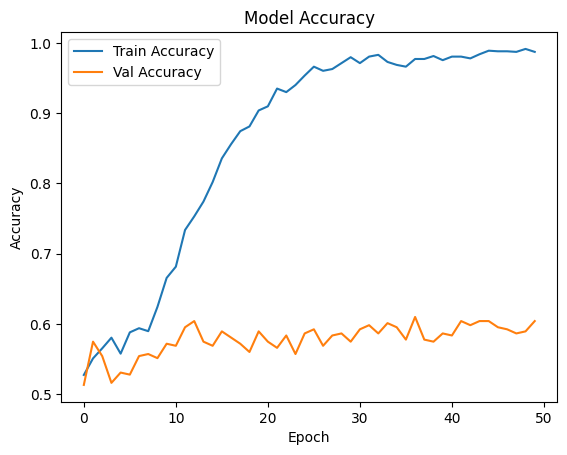

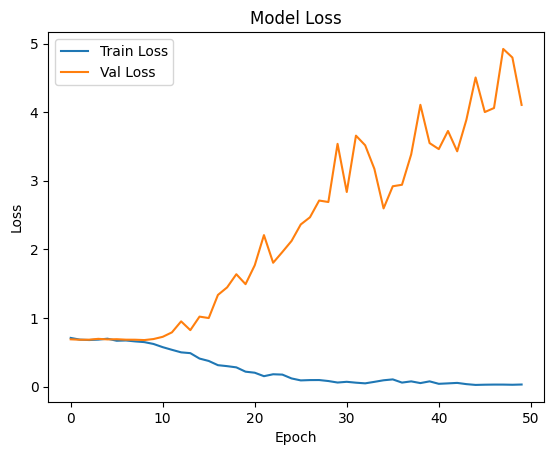

In [ ]:
import matplotlib.pyplot as plt

# Plotting training & validation accuracy values
plt.plot(cnn_history.history['accuracy'], label='Train Accuracy')
plt.plot(cnn_history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.show()

# Plotting training & validation loss values
plt.plot(cnn_history.history['loss'], label='Train Loss')
plt.plot(cnn_history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper left')
plt.show()


## CNN with Unet Segmentation and Antrosopic denoising

In [ ]:
!pip install medpy


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.3/156.3 kB 11.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.4/52.4 MB 37.3 MB/s eta 0:00:00
  Created wheel for medpy: filename=MedPy-0.5.2-cp310-cp310-linux_x86_64.whl size=762836 sha256=3761f60fdde171770a57ed0b456622631ecd0069815d12ba0fc592aa804a1651
  Stored in directory: /root/.cache/pip/wheels/a1/b8/63/bdf557940ec60d1b8822e73ff9fbe7727ac19f009d46b5d175
Successfully built medpy


In [ ]:
import os
import cv2
import numpy as np
from medpy.filter.smoothing import anisotropic_diffusion

def image_processorad(image_path, target_size, unet_model):
    absolute_image_path = os.path.abspath(image_path)
    image = cv2.imread(absolute_image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (target_size[1], target_size[0]))
    image_array = image / 255.0

    denoised_image = np.zeros_like(image_array)
    for i in range(3):
        denoised_image[:, :, i] = anisotropic_diffusion(image_array[:, :, i], niter=10, kappa=50, gamma=0.1)

    input_image = np.expand_dims(denoised_image, axis=0)

    segmented_image = unet_model.predict(input_image)[0]
    segmented_image = (segmented_image > 0.5).astype(np.float32)

    final_image = denoised_image * segmented_image

    return final_image


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam

input_shape = (224, 224, 3)
unet_model = build_unet(input_shape)
unet_model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

full_mass_df = pd.concat([mass_train_df, mass_test_df], axis=0)

target_size = (224, 224, 3)

full_mass_df['processed_images'] = full_mass_df['image_file_path'].apply(lambda x: image_processorad(x, target_size, unet_model))

class_mapper = {'MALIGNANT': 1, 'BENIGN': 0, 'BENIGN_WITHOUT_CALLBACK': 0}

full_mass_df['labels'] = full_mass_df['pathology'].replace(class_mapper)

X_resized = np.array(full_mass_df['processed_images'].tolist())

num_classes = len(np.unique(full_mass_df['labels']))

X_train, X_temp, y_train, y_temp = train_test_split(X_resized, full_mass_df['labels'].values, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.33, random_state=42)

y_train = to_categorical(y_train, num_classes)
y_val = to_categorical(y_val, num_classes)
y_test = to_categorical(y_test, num_classes)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━

In [ ]:
y_train_binary = np.argmax(y_train, axis=1)
y_test_binary = np.argmax(y_test, axis=1)
y_val_binary = np.argmax(y_val, axis=1)

cnn_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax')
])

cnn_model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

cnn_history = cnn_model.fit(X_train, y_train_binary, epochs=10, batch_size=32, validation_data=(X_val, y_val_binary))

evaluation = cnn_model.evaluate(X_test, y_test_binary)


print("Evaluation Loss:", evaluation[0])
print("Evaluation Accuracy:", evaluation[1])


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 8s 140ms/step - accuracy: 0.5200 - loss: 0.7021 - val_accuracy: 0.5132 - val_loss: 0.6934
Epoch 2/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.5530 - loss: 0.6886 - val_accuracy: 0.5132 - val_loss: 0.6916
Epoch 3/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.5583 - loss: 0.6817 - val_accuracy: 0.5367 - val_loss: 0.6887
Epoch 4/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.6711 - loss: 0.6265 - val_accuracy: 0.5543 - val_loss: 0.7079
Epoch 5/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.6841 - loss: 0.6039 - val_accuracy: 0.5308 - val_loss: 0.8535
Epoch 6/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.7906 - loss: 0.4684 - val_accuracy: 0.5455 - val_loss: 0.9055
Epoch 7/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.8367 - loss: 0.3648 - val_accuracy: 0.5601 - val_loss: 0.9435
Epoch 8/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.8831 - loss: 0.2868 - val_accuracy: 0.5543 - 

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Confusion Matrix:
 [[55 32]
 [41 40]]
Classification Report:
               precision    recall  f1-score   support

           0       0.57      0.63      0.60        87
           1       0.56      0.49      0.52        81

    accuracy                           0.57       168
   macro avg       0.56      0.56      0.56       168
weighted avg       0.56      0.57      0.56       168



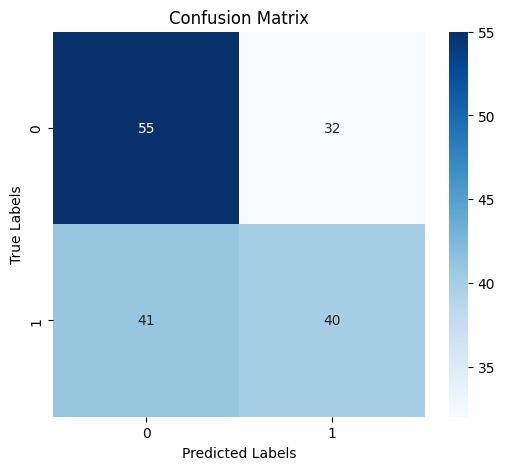

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix

y_test_pred = cnn_model.predict(X_test)
y_test_pred_labels = np.argmax(y_test_pred, axis=1)

conf_matrix = confusion_matrix(y_test_binary, y_test_pred_labels)
class_report = classification_report(y_test_binary, y_test_pred_labels, output_dict=True)

print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", classification_report(y_test_binary, y_test_pred_labels))

plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()




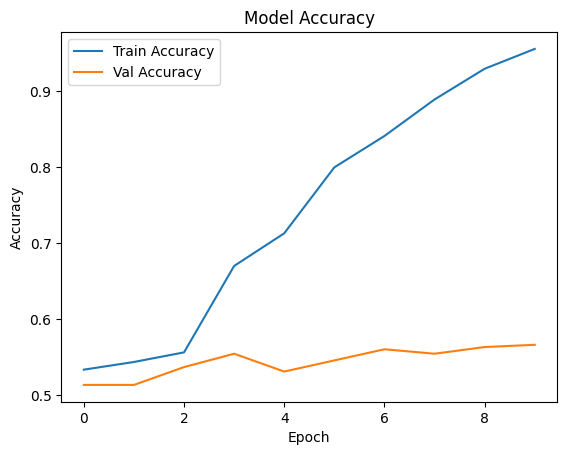

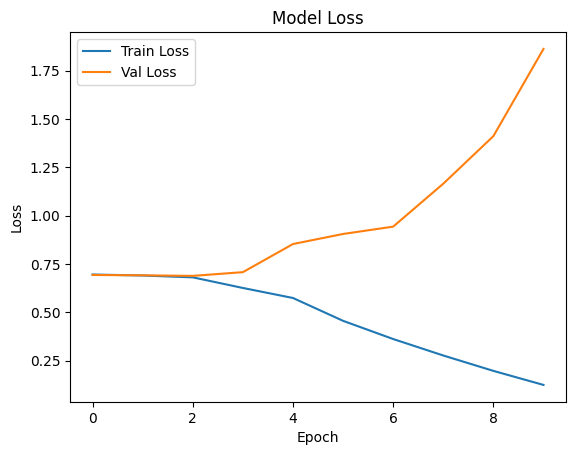

In [ ]:
import matplotlib.pyplot as plt

# Plotting training & validation accuracy values
plt.plot(cnn_history.history['accuracy'], label='Train Accuracy')
plt.plot(cnn_history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.show()

# Plotting training & validation loss values
plt.plot(cnn_history.history['loss'], label='Train Loss')
plt.plot(cnn_history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper left')
plt.show()


In [ ]:
y_train_binary = np.argmax(y_train, axis=1)
y_test_binary = np.argmax(y_test, axis=1)
y_val_binary = np.argmax(y_val, axis=1)

cnn_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax')
])

cnn_model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

cnn_history = cnn_model.fit(X_train, y_train_binary, epochs=50, batch_size=32, validation_data=(X_val, y_val_binary))

evaluation = cnn_model.evaluate(X_test, y_test_binary)

print("Evaluation Loss:", evaluation[0])
print("Evaluation Accuracy:", evaluation[1])


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 8s 141ms/step - accuracy: 0.5128 - loss: 0.7018 - val_accuracy: 0.5132 - val_loss: 0.6924
Epoch 2/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.5399 - loss: 0.6898 - val_accuracy: 0.5132 - val_loss: 0.6919
Epoch 3/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.5580 - loss: 0.6832 - val_accuracy: 0.5279 - val_loss: 0.6917
Epoch 4/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.5954 - loss: 0.6717 - val_accuracy: 0.5308 - val_loss: 0.7115
Epoch 5/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.6392 - loss: 0.6286 - val_accuracy: 0.5513 - val_loss: 0.6876
Epoch 6/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.7269 - loss: 0.5737 - val_accuracy: 0.6070 - val_loss: 0.7656
Epoch 7/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.7717 - loss: 0.4758 - val_accuracy: 0.5660 - val_loss: 0.8623
Epoch 8/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.8711 - loss: 0.3163 - val_accuracy: 0.5777 - 

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step
Confusion Matrix:
 [[56 31]
 [45 36]]
Classification Report:
               precision    recall  f1-score   support

           0       0.55      0.64      0.60        87
           1       0.54      0.44      0.49        81

    accuracy                           0.55       168
   macro avg       0.55      0.54      0.54       168
weighted avg       0.55      0.55      0.54       168



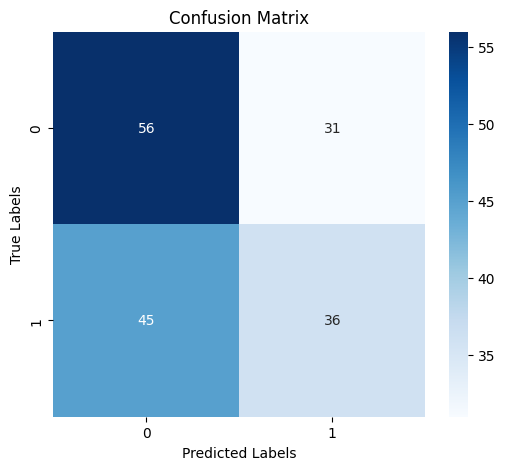

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix

y_test_pred = cnn_model.predict(X_test)
y_test_pred_labels = np.argmax(y_test_pred, axis=1)

conf_matrix = confusion_matrix(y_test_binary, y_test_pred_labels)
class_report = classification_report(y_test_binary, y_test_pred_labels, output_dict=True)

print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", classification_report(y_test_binary, y_test_pred_labels))

plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()




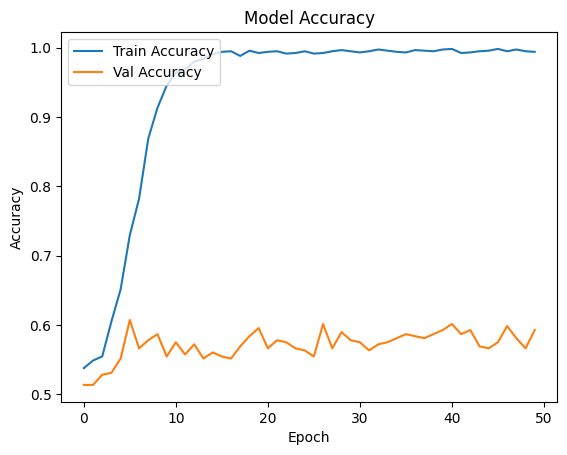

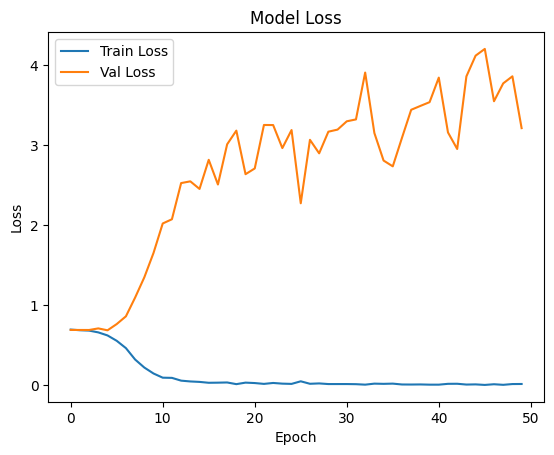

In [ ]:
import matplotlib.pyplot as plt

# Plotting training & validation accuracy values
plt.plot(cnn_history.history['accuracy'], label='Train Accuracy')
plt.plot(cnn_history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.show()

# Plotting training & validation loss values
plt.plot(cnn_history.history['loss'], label='Train Loss')
plt.plot(cnn_history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper left')
plt.show()
